# Tabular Kaggle Project

Guideline for steps for the Kaggle Tabular Project. You will "turn in" a GitHub repository, modeled after [Project Template](https://github.com/UTA-DataScience/ProjectTempate) on the day of the final, Wednesday, Dec 11 at 11 – 1:30 p.m. During the final period we will have about 5 minutes to go over your project and your results.

You can find a list of possible Tabular datasets here on [Excel File in Teams](https://mavsuta.sharepoint.com/:x:/r/teams/Course_2248_data_3402_001-cU7MvhRPSj18z/Shared%20Documents/General/TabularDatasets.xlsx?d=w42833a75094b46a7999548e06732a890&csf=1&web=1&e=seoB4p). You are not limited to these datasets. If you find a Kaggle challenge not listed that you would like to attempt, please go check with Dr. Farbin to make sure it is viable.

This notebook outlines the steps you should follow. The file(s) in the GitHub repository should contain these steps. Note that you will be only considering classification projects.

## Define Project

* Provide Project link.
* Short paragraph describing the challenge.
* Briefly describe the data.


## Data Loading and Initial Look

* Load the data.
* Count the number of rows (data points) and features.
* Any missing values?
* Make a table, where each row is a feature or collection of features:
    * Is the feature categorical or numerical
    * What values?
        * e.g. for categorical: "0,1,2"
        * e.g. for numerical specify the range
    * How many missing values
    * Do you see any outliers?
        * Define outlier.
* For classification is there class imbalance?
* What is the target:
    * Classification: how is the target encoded (e.g. 0 and 1)?
    * Regression: what is the range?

https://www.kaggle.com/competitions/predict-student-performance-from-game-play/overview

The "Predict Student Performance from Game Play" competition challenges participants to predict the correctness of student responses in an educational game, Jo Wilder. The goal is to build a model that accurately predicts whether a student answers a question correctly based on their game interactions. The competition is focused on developing efficient models that can perform well while adhering to strict compute constraints, with evaluation based on the F1 score.

The dataset consists of student interactions with the Jo Wilder educational game, with each record representing a session where students answer a series of questions. Key features include a session ID, question number, and a binary label indicating whether the answer was correct. The data is organized into different levels and segments, with each session consisting of a sequence of questions. Participants must predict the correctness of student responses based on this time-ordered data.

In my approach,

Data Preprocessing:

Handling missing values by filling gaps in categorical and numerical data.
One-hot encoding categorical features such as event_name and name.
Scaling numerical features like elapsed_time and room_coor_x.
Removing constant or redundant features to streamline the dataset.

Feature Engineering:

Aggregating features like fqid_freq and text_fqid_freq to capture interaction frequencies.
Applying dimensionality reduction (PCA) to reduce the feature set size and highlight underlying patterns. Also finding the SD and mean of each column

Model Selection:

Using a Random Forest classifier due to its ability to handle categorical and numerical data without requiring extensive scaling or transformations.
Training the model on a 6,000-sample training set and testing it on a 2,000-sample test set.

Evaluation:

Accuracy was used as the primary metric for evaluating model performance.
Additional metrics like precision and recall were considered but not fully implemented due to dataset imbalance.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [4]:
!kaggle competitions download -c predict-student-performance-from-game-play


100% 965M/968M [00:45<00:00, 18.6MB/s]
100% 968M/968M [00:45<00:00, 22.2MB/s]


In [5]:
!mkdir StudentPerformance

In [6]:
!unzip /content/predict-student-performance-from-game-play.zip -d train

Archive:  /content/predict-student-performance-from-game-play.zip
  inflating: train/jo_wilder/__init__.py  
  inflating: train/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: train/jo_wilder_310/__init__.py  
  inflating: train/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: train/sample_submission.csv  
  inflating: train/test.csv          
  inflating: train/train.csv         
  inflating: train/train_labels.csv  


In [7]:
!ls

predict-student-performance-from-game-play.zip	sample_submission.csv  test.csv
sample_data					StudentPerformance     train


In [8]:
#rows and column
file_paths = ["/content/train/sample_submission.csv", "/content/train/test.csv", "/content/train/train.csv"]

In [9]:
!head -5 "/content/train/sample_submission.csv"

session_id,correct,session_level
20090109393214576_q1,0,0
20090312143683264_q1,0,3
20090312331414616_q1,0,6
20090109393214576_q2,0,0


In [10]:
!head -5 "/content/train/test.csv

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [11]:
!head -5 "/content/train/train.csv"

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,0,0,cutscene_click,basic,0,,-413.99140522263224,-159.31468617022784,380.0,494.0,,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
20090312431273200,1,1323,person_click,basic,0,,-413.99140522263224,-159.31468617022784,380.0,494.0,,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,2,831,person_click,basic,0,,-413.99140522263224,-159.31468617022784,380.0,494.0,,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,3,1147,person_click,basic,0,,-413.99140522263224,-159.31468617022784,380.0,494.0,,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tuni

In [12]:
df = pd.read_csv("/content/train/train.csv", nrows=700000)

# Display the first few rows of the dataframe
print(df.head())

          session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic      0   NaN   
1  20090312431273200      1          1323    person_click  basic      0   NaN   
2  20090312431273200      2           831    person_click  basic      0   NaN   
3  20090312431273200      3          1147    person_click  basic      0   NaN   
4  20090312431273200      4          1863    person_click  basic      0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0  -413.991405  -159.314686          380.0          494.0             NaN   
1  -413.991405  -159.314686          380.0          494.0             NaN   
2  -413.991405  -159.314686          380.0          494.0             NaN   
3  -413.991405  -159.314686          380.0          494.0             NaN   
4  -412.991405  -159.314686          381.0          494.0             NaN   

                            text    fqid          

In [13]:
df

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,20100309412344784,261,454712,navigate_click,undefined,3,NaN,-302.537429,-70.981927,181.0,362.0,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,0,0,1,0-4
699996,20100309412344784,262,454979,navigate_click,undefined,3,NaN,-347.950592,61.014315,189.0,282.0,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,0,0,1,0-4
699997,20100309412344784,263,455277,navigate_click,undefined,3,NaN,-415.291082,66.844311,189.0,282.0,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,0,0,1,0-4
699998,20100309412344784,264,455528,navigate_click,undefined,3,NaN,-471.764139,70.766559,189.0,282.0,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,0,0,1,0-4


In [14]:
total_rows, total_columns = df.shape

missing_values = df.isnull().sum()

print("Total Rows:", total_rows)
print("Total Features:", total_columns)
print("Number of Missing Values:")
print(missing_values)

Total Rows: 700000
Total Features: 20
Number of Missing Values:
session_id             0
index                  0
elapsed_time           0
event_name             0
name                   0
level                  0
page              685215
room_coor_x        62084
room_coor_y        62084
screen_coor_x      62084
screen_coor_y      62084
hover_duration    639784
text              447314
fqid              216576
room_fqid              0
text_fqid         447312
fullscreen             0
hq                     0
music                  0
level_group            0
dtype: int64


In [15]:
#features
categorical_columns = []
numerical_columns = []

# Loop through each column and determine its data type
for column in df.columns:
    if df[column].dtype == 'object':
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

# Print the categorical and numerical columns
print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: ['event_name', 'name', 'text', 'fqid', 'room_fqid', 'text_fqid', 'level_group']
Numerical Columns: ['session_id', 'index', 'elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration', 'fullscreen', 'hq', 'music']


In [16]:
dataset_name = 'train50'

# Initialize an empty dataframe to store feature information
feature_info = pd.DataFrame(columns=['Dataset', 'Feature', 'Type', 'Values'])

# Function to get feature information for a dataset
def get_feature_info(df, dataset_name):
    dataset = df.head()

    # Iterate over each column in the dataset
    for column in dataset.columns:
        values = dataset[column].unique()  # Get unique values
        if dataset[column].dtype == 'object':
            feature_info.loc[len(feature_info)] = [dataset_name, column, 'Categorical', ", ".join(map(str, values))]
        else:
            feature_info.loc[len(feature_info)] = [dataset_name, column, 'Numerical', f"Range: [{values.min()}, {values.max()}]"]

# Get feature information for the dataset
get_feature_info(df, dataset_name)

# Output the feature information table
print(feature_info)

    Dataset         Feature         Type  \
0   train50      session_id    Numerical   
1   train50           index    Numerical   
2   train50    elapsed_time    Numerical   
3   train50      event_name  Categorical   
4   train50            name  Categorical   
5   train50           level    Numerical   
6   train50            page    Numerical   
7   train50     room_coor_x    Numerical   
8   train50     room_coor_y    Numerical   
9   train50   screen_coor_x    Numerical   
10  train50   screen_coor_y    Numerical   
11  train50  hover_duration    Numerical   
12  train50            text  Categorical   
13  train50            fqid  Categorical   
14  train50       room_fqid  Categorical   
15  train50       text_fqid  Categorical   
16  train50      fullscreen    Numerical   
17  train50              hq    Numerical   
18  train50           music    Numerical   
19  train50     level_group  Categorical   

                                               Values  
0       Range: [200

In [17]:
missing_threshold = 0.1 # aka 10% missing values

# Filter columns with significant missing values and convert to numeric
columns_with_missing = df.columns[df.isnull().mean() > missing_threshold]
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
columns_with_missing = [col for col in columns_with_missing if col in numeric_columns]

# Impute missing values with median
df[columns_with_missing] = df[columns_with_missing].fillna(df[columns_with_missing].median())
print(df.isnull().sum())

session_id             0
index                  0
elapsed_time           0
event_name             0
name                   0
level                  0
page                   0
room_coor_x        62084
room_coor_y        62084
screen_coor_x      62084
screen_coor_y      62084
hover_duration         0
text              447314
fqid              216576
room_fqid              0
text_fqid         447312
fullscreen             0
hq                     0
music                  0
level_group            0
dtype: int64


In [18]:
# Determine numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Print the identified numerical and categorical columns
print("Numerical columns:")
print(numerical_cols)
print("\nCategorical columns:")
print(categorical_cols)

Numerical columns:
Index(['session_id', 'index', 'elapsed_time', 'level', 'page', 'room_coor_x',
       'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration',
       'fullscreen', 'hq', 'music'],
      dtype='object')

Categorical columns:
Index(['event_name', 'name', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'level_group'],
      dtype='object')


In [19]:
#outliers
#identify number of outliers in each numerical column
num_cols=df.select_dtypes(include=['int', 'float']).columns
df_num=df[num_cols]
for col in df_num.columns:
   q1=df_num[col].quantile(0.25)
   q3=df_num[col].quantile(0.75)
   IQR=q3-q1
   outliers=df_num[((df_num[col]<(q1-1.5*IQR)) | (df_num[col]>(q3+1.5*IQR)))]
   print(f'{col} outlier count: {outliers.value_counts().sum()}')

session_id outlier count: 27207
index outlier count: 16324
elapsed_time outlier count: 45752
level outlier count: 0
page outlier count: 13115
room_coor_x outlier count: 10011
room_coor_y outlier count: 32541
screen_coor_x outlier count: 676
screen_coor_y outlier count: 5009
hover_duration outlier count: 0
fullscreen outlier count: 89381
hq outlier count: 92172
music outlier count: 65342


In [20]:
import pandas as pd

# Define the numerical columns from your dataset
numerical_columns = [
    'elapsed_time', 'level', 'room_coor_x', 'room_coor_y', 'screen_coor_x',
    'screen_coor_y', 'hover_duration', 'fullscreen', 'hq', 'music'
]

# Loop through the numerical columns and detect outliers
outliers_dict = {}  # To store outliers for each column
for col in numerical_columns:
    # Calculate Q1, Q3, and IQR for each column
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1

    # Identify outliers
    outliers = df[(df[col] < (q1 - 1.5 * IQR)) | (df[col] > (q3 + 1.5 * IQR))]

    # Store outliers in dictionary for each column
    outliers_dict[col] = outliers

    # Display outliers for the current column
    print(f"Outliers for column: {col}")
    print(outliers[[col]])  # Display only the outlier values of the column
    print("\n")

for col, outliers in outliers_dict.items():
    print(f"Number of outliers in {col}: {len(outliers)}")

Outliers for column: elapsed_time
        elapsed_time
9723         4137147
9724         4138063
9725         4137832
9726         4138849
9727         4139313
...              ...
692632       5074302
692633       5074550
692634       5076338
692635       5076829
692636       5078810

[50918 rows x 1 columns]


Outliers for column: level
Empty DataFrame
Columns: [level]
Index: []


Outliers for column: room_coor_x
        room_coor_x
502    -1595.109390
535    -1447.131615
536    -1577.745563
537    -1693.729280
538    -1801.970481
...             ...
699263 -1594.756122
699264 -1700.496986
699265 -1749.203335
699266 -1808.138564
699267 -1864.044046

[10011 rows x 1 columns]


Outliers for column: room_coor_y
        room_coor_y
51       401.948788
68       416.026789
232      419.495320
550      426.008774
551      460.204411
...             ...
699721   452.271976
699790   506.164061
699800   445.968489
699833   385.395162
699845   389.019735

[32541 rows x 1 columns]


Outliers for

In [21]:
# List of numerical columns to check for outliers
numerical_columns = ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

# Loop through each column to handle outliers
for column in numerical_columns:
    # Calculate the Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    print(f"Outliers handled for column: {column}")

Outliers handled for column: elapsed_time
Outliers handled for column: room_coor_x
Outliers handled for column: room_coor_y
Outliers handled for column: screen_coor_x
Outliers handled for column: screen_coor_y
Outliers handled for column: hover_duration


In [22]:
outliers.describe()

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
count,7.213100e+04,72131.000000,7.213100e+04,72131.000000,72131.000000,65342.000000,65342.000000,65342.000000,65342.000000,72131.000000,72131.000000,72131.000000,72131.0
mean,2.009980e+16,659.051143,4.221900e+06,12.312043,3.005490,-62.264139,-110.118804,447.514585,379.181308,496.123775,0.116829,0.299691,0.0
std,1.843115e+12,460.777669,2.250241e+07,6.529451,0.293887,515.101391,216.734235,241.620655,127.324062,1329.809379,0.321219,0.458126,0.0
min,2.009031e+16,0.000000,0.000000e+00,0.000000,0.000000,-1971.924817,-909.041957,0.000000,6.000000,9.000000,0.000000,0.000000,0.0
25%,2.010011e+16,296.000000,5.010730e+05,6.000000,3.000000,-358.007684,-209.470596,262.000000,297.000000,414.000000,0.000000,0.000000,0.0
50%,2.010011e+16,608.000000,1.205360e+06,13.000000,3.000000,-18.000000,-93.820853,438.000000,391.000000,414.000000,0.000000,0.000000,0.0
75%,2.010021e+16,920.000000,2.202378e+06,18.000000,3.000000,280.833569,28.791693,642.000000,467.750000,414.000000,0.000000,1.000000,0.0
max,2.010031e+16,2510.000000,4.293728e+08,22.000000,6.000000,1242.145681,522.082229,1013.000000,767.000000,214220.000000,1.000000,1.000000,0.0


In [23]:
# List of numerical columns to describe
numerical_columns = ['elapsed_time', 'level', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration', 'fullscreen', 'hq', 'music']

# Loop through each column and describe it
for column in numerical_columns:
    column_description = df[column].describe()
    print(f"Description for column: {column}")
    print(column_description)
    print("\n" + "-"*50 + "\n")

Description for column: elapsed_time
count    5.488890e+05
mean     1.116834e+06
std      8.944479e+05
min      0.000000e+00
25%      3.955030e+05
50%      9.261580e+05
75%      1.622513e+06
max      4.135814e+06
Name: elapsed_time, dtype: float64

--------------------------------------------------

Description for column: level
count    548889.000000
mean         11.423142
std           6.491210
min           0.000000
25%           6.000000
50%          11.000000
75%          18.000000
max          22.000000
Name: level, dtype: float64

--------------------------------------------------

Description for column: room_coor_x
count    548889.000000
mean        -36.927087
std         471.130609
min       -1308.789411
25%        -322.562066
50%          -8.383641
75%         278.362643
max        1246.065039
Name: room_coor_x, dtype: float64

--------------------------------------------------

Description for column: room_coor_y
count    548889.000000
mean        -87.107896
std         175

In [24]:
target_column = 'level'

In [25]:
columns_to_drop = ['name','event_name','session_id']
df.drop(columns=columns_to_drop, inplace=True)

In [26]:
# Check the distribution of the target variable (level_group)
df['level_group'].value_counts()

,count
level_group,
13-22,253392
5-12,200671
0-4,94826


In [27]:
# Check the range for regression (min and max values)
df['level_group'].min(), df['level_group'].max()

('0-4', '5-12')

In [28]:
# Check for non-numeric columns
print(df.dtypes)

# Check for 'undefined' or similar values
print(df[df.applymap(lambda x: isinstance(x, str))].head())

index               int64
elapsed_time        int64
level               int64
page              float64
room_coor_x       float64
room_coor_y       float64
screen_coor_x     float64
screen_coor_y     float64
hover_duration    float64
text               object
fqid               object
room_fqid          object
text_fqid          object
fullscreen          int64
hq                  int64
music               int64
level_group        object
dtype: object


<ipython-input-28-d328d2ce5860>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df[df.applymap(lambda x: isinstance(x, str))].head())


   index  elapsed_time  level  page  room_coor_x  room_coor_y  screen_coor_x  \
0    NaN           NaN    NaN   NaN          NaN          NaN            NaN   
1    NaN           NaN    NaN   NaN          NaN          NaN            NaN   
2    NaN           NaN    NaN   NaN          NaN          NaN            NaN   
3    NaN           NaN    NaN   NaN          NaN          NaN            NaN   
4    NaN           NaN    NaN   NaN          NaN          NaN            NaN   

   screen_coor_y  hover_duration                           text    fqid  \
0            NaN             NaN                      undefined   intro   
1            NaN             NaN  Whatcha doing over there, Jo?  gramps   
2            NaN             NaN         Just talking to Teddy.  gramps   
3            NaN             NaN     I gotta run to my meeting!  gramps   
4            NaN             NaN            Can I come, Gramps?  gramps   

                        room_fqid  \
0  tunic.historicalsociety.clos

level_group
13-22    253392
5-12     200671
0-4       94826
Name: count, dtype: int64


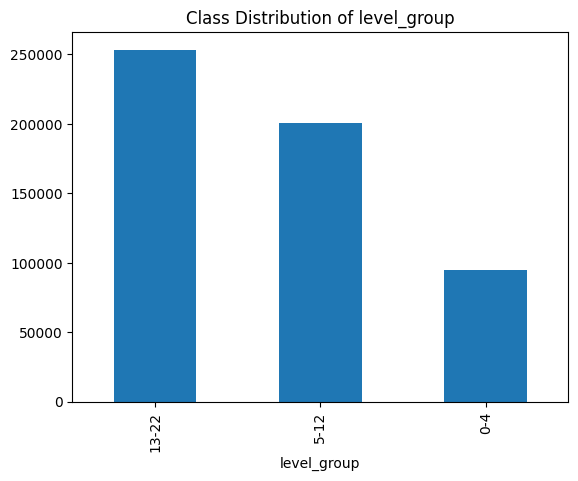

  level_group  level_group_encoded
0         0-4                    0
1         0-4                    0
2         0-4                    0
3         0-4                    0
4         0-4                    0


In [29]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. Check the target variable distribution
print(df['level_group'].value_counts())

# plot the distribution
df['level_group'].value_counts().plot(kind='bar', title='Class Distribution of level_group')
plt.show()

# 2. Encode the target variable
label_encoder = LabelEncoder()
df['level_group_encoded'] = label_encoder.fit_transform(df['level_group'])

# Check the encoding
print(df[['level_group', 'level_group_encoded']].head())

# 3. Handle class imbalance
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['level_group', 'level_group_encoded'])  # Features
y = df['level_group_encoded']  # Target variable

In [30]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
le = LabelEncoder()

# Apply encoding to each relevant column
for col in ['fqid', 'room_fqid', 'text_fqid']:
    X[col] = le.fit_transform(X[col].astype(str))

In [31]:
print(X.dtypes)

index               int64
elapsed_time        int64
level               int64
page              float64
room_coor_x       float64
room_coor_y       float64
screen_coor_x     float64
screen_coor_y     float64
hover_duration    float64
text               object
fqid                int64
room_fqid           int64
text_fqid           int64
fullscreen          int64
hq                  int64
music               int64
dtype: object


In [32]:
# Load the first 10,000 rows of the dataset
train_df = pd.read_csv('/content/train/train.csv', nrows=10000)

print("Subset of training dataset loaded:")
print(train_df.head())

Subset of training dataset loaded:
          session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic      0   NaN   
1  20090312431273200      1          1323    person_click  basic      0   NaN   
2  20090312431273200      2           831    person_click  basic      0   NaN   
3  20090312431273200      3          1147    person_click  basic      0   NaN   
4  20090312431273200      4          1863    person_click  basic      0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0  -413.991405  -159.314686          380.0          494.0             NaN   
1  -413.991405  -159.314686          380.0          494.0             NaN   
2  -413.991405  -159.314686          380.0          494.0             NaN   
3  -413.991405  -159.314686          380.0          494.0             NaN   
4  -412.991405  -159.314686          381.0          494.0             NaN   

               

In [33]:
# Check unique values and distribution
if 'correct' in train_df.columns:
    print("\nUnique values in 'correct':", train_df['correct'].unique())
    print("\nValue counts in 'correct':")
    print(train_df['correct'].value_counts(normalize=True))

In [34]:
print("Columns in the training dataset:")
print(train_df.columns)

Columns in the training dataset:
Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group'],
      dtype='object')


In [35]:
# Apply the lambda function directly to the Pandas DataFrame
train_df['correct'] = train_df['event_name'].apply(
    lambda x: 1 if isinstance(x, str) and 'correct' in x else 0
)

# Check the result
print(train_df[['event_name', 'correct']].head())

       event_name  correct
0  cutscene_click        0
1    person_click        0
2    person_click        0
3    person_click        0
4    person_click        0


In [36]:
# Define features (X) and target (y)
X = train_df.drop(columns=['correct', 'session_id', 'index'])  # Drop irrelevant columns
y = train_df['correct']

# Check the shapes of X and y
print("Feature set shape:", X.shape)
print("Target shape:", y.shape)

Feature set shape: (10000, 18)
Target shape: (10000,)


In [37]:
print("Columns in the dataset:")
print(train_df.columns)

#check unique values for the target variable

print("\nUnique values in the target column:")
print(train_df['correct'].unique())

Columns in the dataset:
Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group', 'correct'],
      dtype='object')

Unique values in the target column:
[0]


In [38]:
print("Summary statistics for numerical columns:")
print(train_df.describe())

Summary statistics for numerical columns:
         session_id         index  elapsed_time         level        page  \
count  1.000000e+04  10000.000000  1.000000e+04  10000.000000  234.000000   
mean   2.009031e+16    616.590000  1.255310e+06     12.677900    3.504274   
std    8.051530e+08    427.289261  1.087167e+06      6.633804    2.175257   
min    2.009031e+16      0.000000  0.000000e+00      0.000000    0.000000   
25%    2.009031e+16    264.000000  3.944885e+05      7.000000    1.000000   
50%    2.009031e+16    581.000000  9.308475e+05     15.000000    4.000000   
75%    2.009031e+16    876.000000  1.918895e+06     18.000000    5.000000   
max    2.009031e+16   1875.000000  4.208427e+06     22.000000    6.000000   

       room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
count  8985.000000  8985.000000    8985.000000    8985.000000      987.000000   
mean    -47.360699  -101.108097     472.519087     387.736895     1217.531915   
std     511.633151   

In [39]:
print("Unique values in categorical columns:")
categorical_columns = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid', 'level_group']
for col in categorical_columns:
    print(f"{col}: {train_df[col].nunique()} unique values")

Unique values in categorical columns:
event_name: 11 unique values
name: 6 unique values
fqid: 118 unique values
room_fqid: 19 unique values
text_fqid: 104 unique values
level_group: 3 unique values


In [40]:
print("Target value counts:")
print(train_df['correct'].value_counts())

Target value counts:
correct
0    10000
Name: count, dtype: int64


In [41]:
submission_path = '/content/sample_submission.csv'
submission_df = pd.read_csv(submission_path)

print("Sample submission file preview:")
print(submission_df.head())

Sample submission file preview:
             session_id  correct  session_level
0  20090109393214576_q1        0              0
1  20090312143683264_q1        0              3
2  20090312331414616_q1        0              6
3  20090109393214576_q2        0              0
4  20090312143683264_q2        0              3


In [42]:
# Compute the class distribution directly
class_distribution = train_df['correct'].value_counts(normalize=True)

# Print the class distribution
print("Class distribution (target 'correct'):")
print(class_distribution)

# Check for class imbalance
if class_distribution[0] > 0.7:  # Adjust threshold as needed
    print("Warning: Possible class imbalance detected.")

Class distribution (target 'correct'):
correct
0    1.0
Name: proportion, dtype: float64


In [43]:
# Display a sample of the 'correct' column
print("Sample data from 'correct' column:")
print(train_df['correct'].head(20))  # Display first 20 entries

Sample data from 'correct' column:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: correct, dtype: int64


In [44]:
# Check for missing values in the 'correct' column
print("Missing values in 'correct' column:", train_df['correct'].isnull().sum())

Missing values in 'correct' column: 0


In [45]:
# Check other columns for potential targets
print(train_df[['event_name', 'name', 'elapsed_time']].head(20))

           event_name       name  elapsed_time
0      cutscene_click      basic             0
1        person_click      basic          1323
2        person_click      basic           831
3        person_click      basic          1147
4        person_click      basic          1863
5        person_click      basic          3423
6        person_click      basic          5197
7        person_click      basic          6180
8        person_click      basic          7014
9        person_click      basic          7946
10     navigate_click  undefined          9133
11       person_click      basic         10263
12     navigate_click  undefined         12030
13  observation_click      basic         13030
14     navigate_click  undefined         14814
15     navigate_click  undefined         15498
16     navigate_click  undefined         16046
17     navigate_click  undefined         17462
18     navigate_click  undefined         18164
19     navigate_click  undefined         18796


In [46]:
# One-hot encode the 'event_name' and 'name' columns
train_df_encoded = pd.get_dummies(train_df, columns=['event_name', 'name'])

# Check the encoded dataframe
print(train_df_encoded.head())

          session_id  index  elapsed_time  level  page  room_coor_x  \
0  20090312431273200      0             0      0   NaN  -413.991405   
1  20090312431273200      1          1323      0   NaN  -413.991405   
2  20090312431273200      2           831      0   NaN  -413.991405   
3  20090312431273200      3          1147      0   NaN  -413.991405   
4  20090312431273200      4          1863      0   NaN  -412.991405   

   room_coor_y  screen_coor_x  screen_coor_y  hover_duration  ...  \
0  -159.314686          380.0          494.0             NaN  ...   
1  -159.314686          380.0          494.0             NaN  ...   
2  -159.314686          380.0          494.0             NaN  ...   
3  -159.314686          380.0          494.0             NaN  ...   
4  -159.314686          381.0          494.0             NaN  ...   

  event_name_object_click event_name_object_hover  \
0                   False                   False   
1                   False                   False   

In [47]:
from sklearn.preprocessing import LabelEncoder

# Label encode the 'level_group' column
label_encoder = LabelEncoder()
train_df['level_group_encoded'] = label_encoder.fit_transform(train_df['level_group'])

# Check the encoding
print(train_df[['level_group', 'level_group_encoded']].head())

  level_group  level_group_encoded
0         0-4                    0
1         0-4                    0
2         0-4                    0
3         0-4                    0
4         0-4                    0


In [48]:
train_df = pd.get_dummies(train_df, columns=['event_name', 'name', 'level_group'], drop_first=True)

In [49]:
for col in ['fqid', 'room_fqid', 'text_fqid']:
    freq_encoding = train_df[col].value_counts().to_dict()
    train_df[f'{col}_freq'] = train_df[col].map(freq_encoding)

In [50]:
for col in ['fqid', 'room_fqid', 'text_fqid']:
    target_mean = train_df.groupby(col)['correct'].mean().to_dict()
    train_df[f'{col}_target_enc'] = train_df[col].map(target_mean)

In [51]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import pandas as pd

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
filled_data = imputer.fit_transform(train_df[['fqid_freq', 'room_fqid_freq']])

# Apply PCA with n_components=2 (maximum allowed for 2 features)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(filled_data)

# Convert PCA results into a DataFrame
train_df_pca = pd.DataFrame(reduced_features, columns=[f'pca_{i}' for i in range(1, 3)])

# Combine PCA results with the original DataFrame
train_df = pd.concat([train_df.reset_index(drop=True), train_df_pca], axis=1)

print(train_df.head())

          session_id  index  elapsed_time  level  page  room_coor_x  \
0  20090312431273200      0             0      0   NaN  -413.991405   
1  20090312431273200      1          1323      0   NaN  -413.991405   
2  20090312431273200      2           831      0   NaN  -413.991405   
3  20090312431273200      3          1147      0   NaN  -413.991405   
4  20090312431273200      4          1863      0   NaN  -412.991405   

   room_coor_y  screen_coor_x  screen_coor_y  hover_duration  ...  \
0  -159.314686          380.0          494.0             NaN  ...   
1  -159.314686          380.0          494.0             NaN  ...   
2  -159.314686          380.0          494.0             NaN  ...   
3  -159.314686          380.0          494.0             NaN  ...   
4  -159.314686          381.0          494.0             NaN  ...   

  level_group_13-22 level_group_5-12 fqid_freq room_fqid_freq  text_fqid_freq  \
0             False            False      22.0            339            22.0

In [52]:
# Define features (X) and target (y)
X = train_df.drop(columns=['correct', 'session_id', 'index'])  # Adjust based on your target
y = train_df['correct']

In [53]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (8000, 41)
Test set size: (2000, 41)


In [54]:
# Identify non-numeric columns in X_train
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['text', 'fqid', 'room_fqid', 'text_fqid'], dtype='object')


In [55]:
X_train_encoded = pd.get_dummies(X_train, columns=non_numeric_columns, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=non_numeric_columns, drop_first=True)

# Align columns in training and test sets
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [56]:
# Fill missing values
X_train_encoded = X_train_encoded.fillna(0)
X_test_encoded = X_test_encoded.fillna(0)

In [57]:
# Drop the 'text' column if not relevant for modeling
X_train_encoded = X_train.drop(columns=['text'])
X_test_encoded = X_test.drop(columns=['text'])

In [58]:
# Apply one-hot encoding to the categorical columns
X_train_encoded = pd.get_dummies(X_train_encoded, columns=['fqid', 'room_fqid', 'text_fqid'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test_encoded, columns=['fqid', 'room_fqid', 'text_fqid'], drop_first=True)

# Align the columns between the training and test data
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the Random Forest model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_encoded)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



## Data Visualization

* For classification: compare histogram every feature between the classes. Lots of examples of this in class.
* For regression:
    * Define 2 or more class based on value of the regression target.
        * For example: if regression target is between 0 and 1:
            * 0.0-0.25: Class 1
            * 0.25-0.5: Class 2
            * 0.5-0.75: Class 3
            * 0.75-1.0: Class 4
    * Compare histograms of the features between the classes.
        
* Note that for categorical features, often times the information in the histogram could be better presented in a table.    
* Make comments on what features look most promising for ML task.

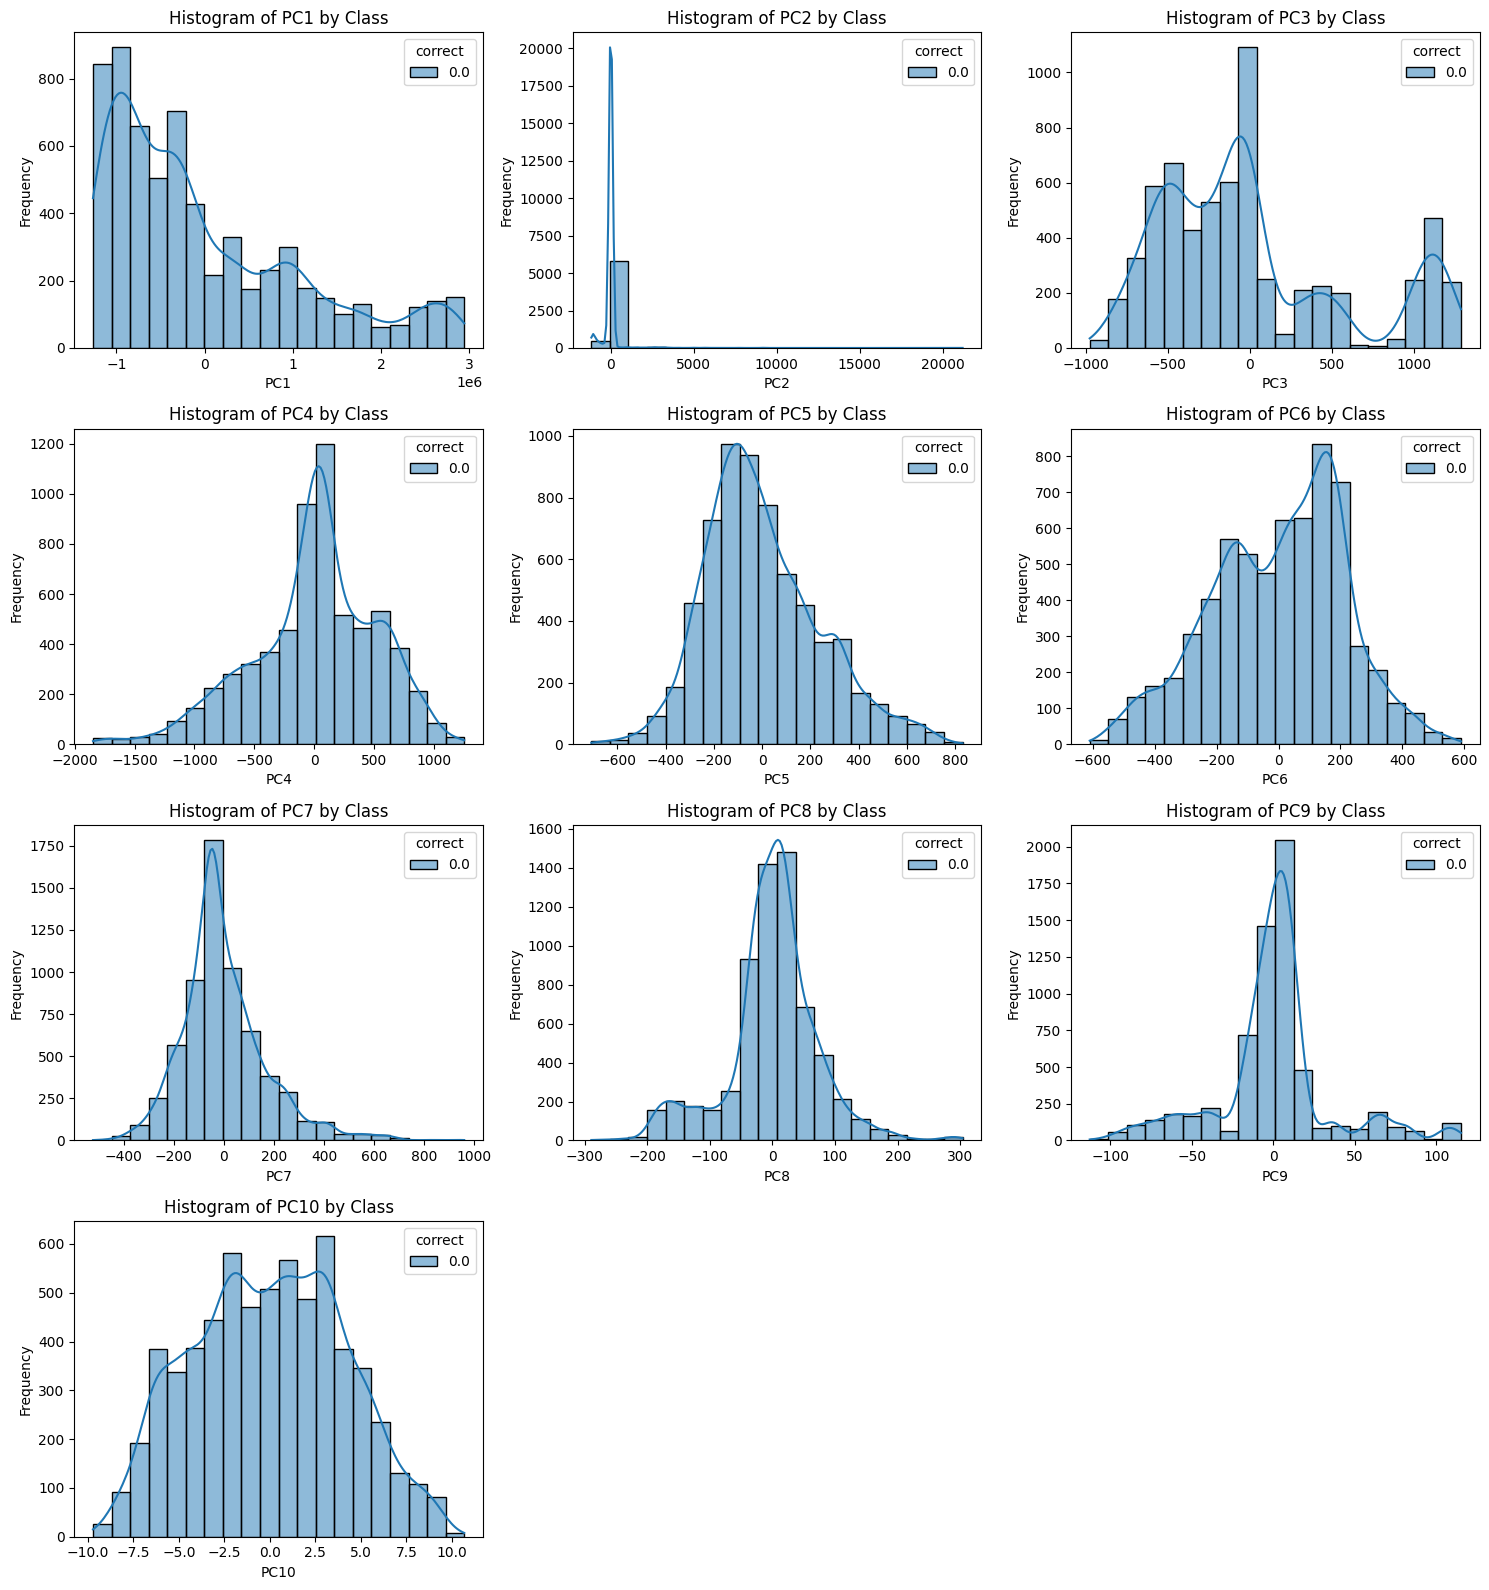

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Select only numerical columns
numeric_features = X_train_encoded.select_dtypes(include=["number"])

# Handle missing values using imputation (mean strategy)
imputer = SimpleImputer(strategy="mean")
numeric_features_imputed = pd.DataFrame(imputer.fit_transform(numeric_features), columns=numeric_features.columns)

# Check and remove low-variance features
low_variance_features = numeric_features_imputed.columns[numeric_features_imputed.var() < 1e-6]
numeric_features_imputed = numeric_features_imputed.drop(columns=low_variance_features)

# Optionally reduce dimensionality if necessary
if numeric_features_imputed.shape[1] > 10:  # Reduce dimensions for high-dimensional datasets
    pca = PCA(n_components=10)
    X_train_encoded_reduced = pd.DataFrame(
        pca.fit_transform(numeric_features_imputed),
        columns=[f'PC{i+1}' for i in range(pca.n_components_)]
    )
else:
    X_train_encoded_reduced = numeric_features_imputed

# Get feature names
features = X_train_encoded_reduced.columns

# Determine grid size
num_features = len(features)
num_cols = 3
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

# Set up subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

# Plot histograms
for i, feature in enumerate(features):
    ax = axes[i]
    sns.histplot(data=X_train_encoded_reduced, x=feature, hue=y_train, kde=True, ax=ax, bins=20, multiple="stack")
    ax.set_title(f"Histogram of {feature} by Class")
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [61]:
import numpy as np

# Create classes based on the regression target
bins = [0, 0.25, 0.5, 0.75, 1]
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
y_train_classified = pd.cut(y_train, bins=bins, labels=labels, right=False)

# Add the classes to the DataFrame for plotting
X_train_encoded['y_class'] = y_train_classified

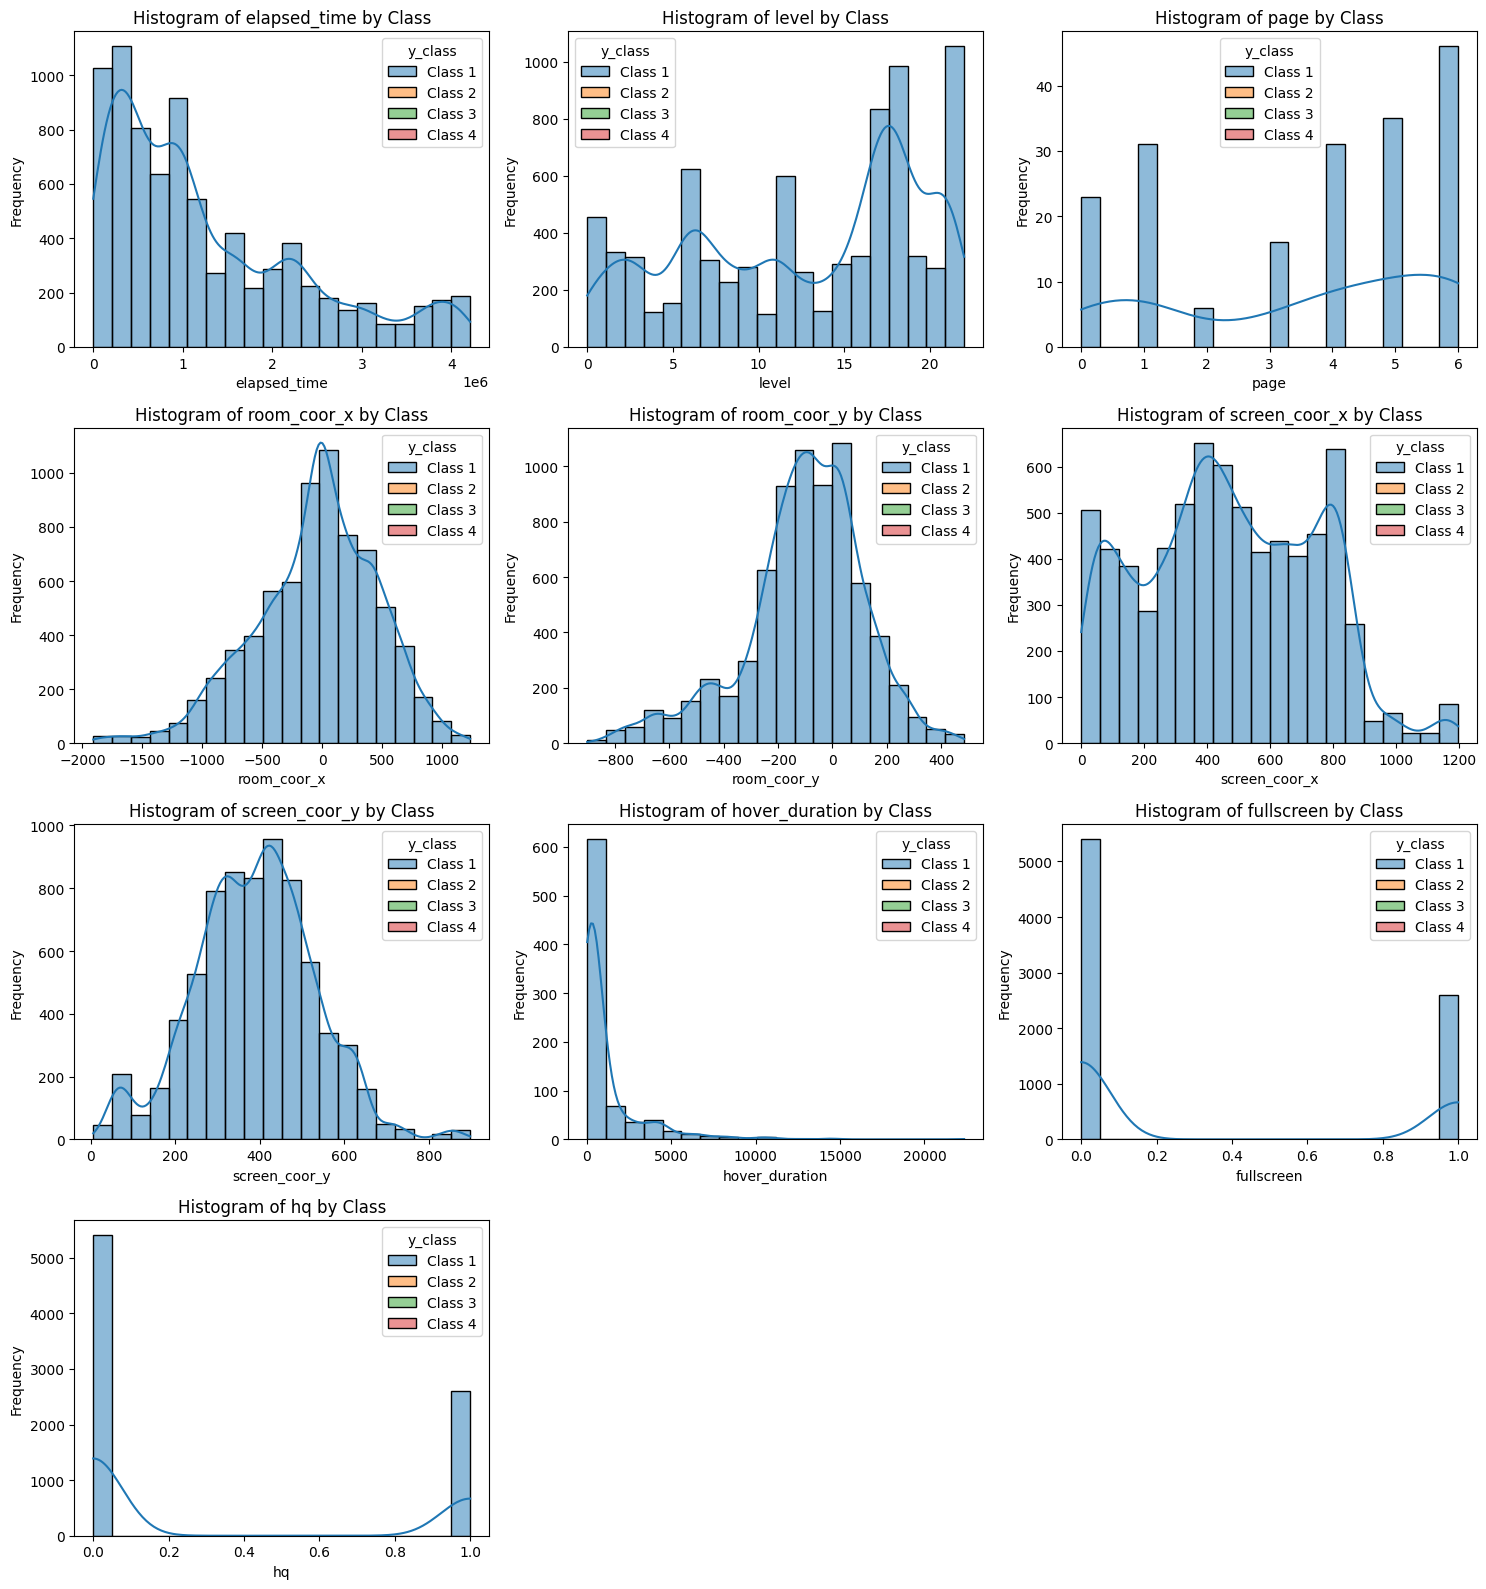

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features (again, excluding the target)
features = X_train_encoded.columns[:-1]  # Exclude the target class column

# Reduce the number of features to plot (e.g., top 10 most important)
top_features = features[:10]

# Set up a grid of subplots for each feature with reduced figure size
num_cols = 3
num_rows = (len(top_features) // num_cols) + (len(top_features) % num_cols > 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 4)) # Reduced figsize
axes = axes.flatten()

for i, feature in enumerate(top_features): # Iterate over top_features
    ax = axes[i]
    sns.histplot(data=X_train_encoded, x=feature, hue='y_class', kde=True, ax=ax, bins=20, multiple="stack")
    ax.set_title(f"Histogram of {feature} by Class")
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Data Cleaning and Preperation for Machine Learning

* Perform any data cleaning. Be clear what are you doing, for what feature.
* Determinine if rescaling is important for your Machine Learning model.
    * If so select strategy for each feature.
    * Apply rescaling.
* Visualize the features before and after cleaning and rescaling.
* One-hot encode your categorical features.

In [63]:
# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values:\n{missing_values}")

# Fill missing values for numerical columns only (ignoring non-numeric columns like 'session_id')
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Check again after handling missing values
missing_values = df.isnull().sum()
print(f"Missing values after handling:\n{missing_values}")

Missing values:
index                       0
elapsed_time                0
level                       0
page                        0
room_coor_x                 0
room_coor_y                 0
screen_coor_x               0
screen_coor_y               0
hover_duration              0
text                   320707
fqid                   173121
room_fqid                   0
text_fqid              320705
fullscreen                  0
hq                          0
music                       0
level_group                 0
level_group_encoded         0
dtype: int64
Missing values after handling:
index                       0
elapsed_time                0
level                       0
page                        0
room_coor_x                 0
room_coor_y                 0
screen_coor_x               0
screen_coor_y               0
hover_duration              0
text                   320707
fqid                   173121
room_fqid                   0
text_fqid              320705
fullscreen

In [64]:
print("Available columns in the DataFrame:")
print(train_df.columns)

Available columns in the DataFrame:
Index(['session_id', 'index', 'elapsed_time', 'level', 'page', 'room_coor_x',
       'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration',
       'text', 'fqid', 'room_fqid', 'text_fqid', 'fullscreen', 'hq', 'music',
       'correct', 'level_group_encoded', 'event_name_cutscene_click',
       'event_name_map_click', 'event_name_map_hover',
       'event_name_navigate_click', 'event_name_notebook_click',
       'event_name_notification_click', 'event_name_object_click',
       'event_name_object_hover', 'event_name_observation_click',
       'event_name_person_click', 'name_close', 'name_next', 'name_open',
       'name_prev', 'name_undefined', 'level_group_13-22', 'level_group_5-12',
       'fqid_freq', 'room_fqid_freq', 'text_fqid_freq', 'fqid_target_enc',
       'room_fqid_target_enc', 'text_fqid_target_enc', 'pca_1', 'pca_2'],
      dtype='object')


In [65]:
# Check for missing values in the encoded columns
missing_values = train_df.isnull().sum()
print("Missing values after encoding:")
print(missing_values[missing_values > 0])

Missing values after encoding:
page                    9766
room_coor_x             1015
room_coor_y             1015
screen_coor_x           1015
screen_coor_y           1015
hover_duration          9013
text                    6368
fqid                    3031
text_fqid               6368
fqid_freq               3031
text_fqid_freq          6368
fqid_target_enc         3031
text_fqid_target_enc    6368
dtype: int64


In [66]:
# Fill missing values in encoded columns
train_df.fillna(0, inplace=True)

In [67]:
# Check for variations in column names
if 'Text' in train_df.columns:
    train_df['Text'].fillna('unknown', inplace=True)  # Adjust to match the column name

In [68]:
# Check and remove duplicate rows
df.drop_duplicates(inplace=True)

In [69]:
# Identify outliers using Z-scores or Interquartile Range (IQR)
from scipy.stats import zscore

# Z-score for outlier detection
z_scores = zscore(df.select_dtypes(include=['float64', 'int64']))
df = df[(z_scores < 3).all(axis=1)]  # Keep rows where z-score < 3

In [70]:
# Print the column names of your DataFrame
print(df.columns)

Index(['index', 'elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'hover_duration', 'text', 'fqid',
       'room_fqid', 'text_fqid', 'fullscreen', 'hq', 'music', 'level_group',
       'level_group_encoded'],
      dtype='object')


In [71]:
# List numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
print(f"Numerical Columns: {numerical_columns}")

# Check if rescaling is necessary
df[numerical_columns].describe()

Numerical Columns: Index(['index', 'elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'hover_duration', 'fullscreen', 'hq',
       'music', 'level_group_encoded'],
      dtype='object')


,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music,level_group_encoded
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
print("Summary of numerical columns:")
print(train_df[['index', 'elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'hover_duration', 'fullscreen', 'hq',
       'music', 'level_group_encoded']].info())

Summary of numerical columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                10000 non-null  int64  
 1   elapsed_time         10000 non-null  int64  
 2   level                10000 non-null  int64  
 3   page                 10000 non-null  float64
 4   room_coor_x          10000 non-null  float64
 5   room_coor_y          10000 non-null  float64
 6   screen_coor_x        10000 non-null  float64
 7   screen_coor_y        10000 non-null  float64
 8   hover_duration       10000 non-null  float64
 9   fullscreen           10000 non-null  int64  
 10  hq                   10000 non-null  int64  
 11  music                10000 non-null  int64  
 12  level_group_encoded  10000 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 1015.8 KB
None


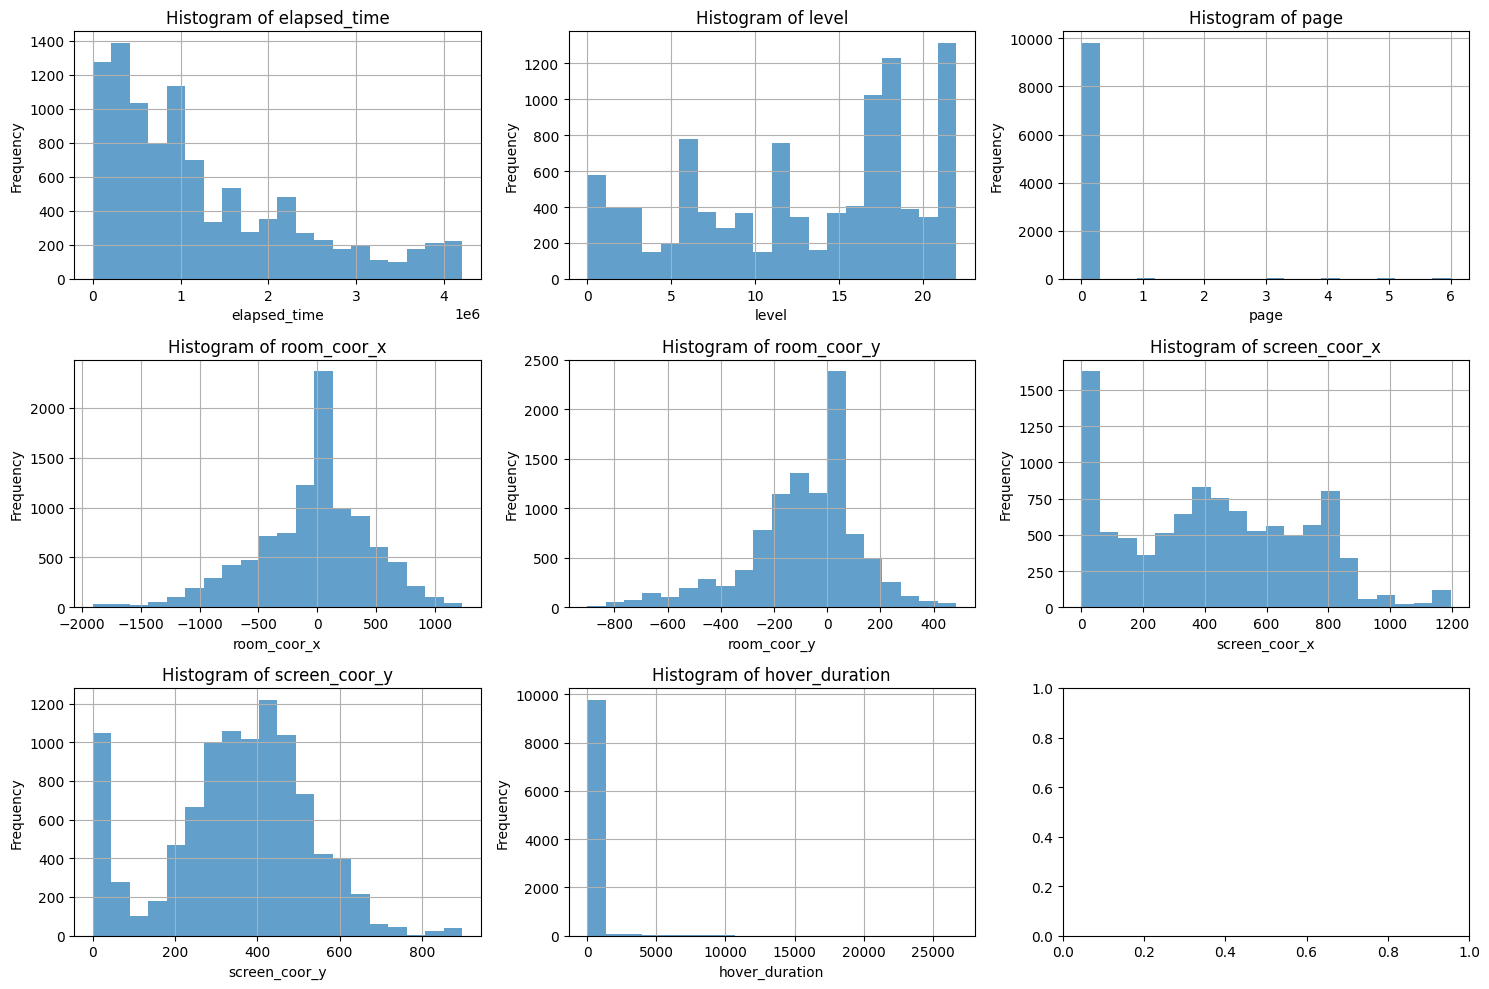

In [73]:
import matplotlib.pyplot as plt

# Plot histograms for numerical features
numerical_columns = ['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
                     'screen_coor_x', 'screen_coor_y', 'hover_duration']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    train_df[col].hist(bins=20, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [74]:
# Cap outliers for room_coor_x
train_df['room_coor_x'] = train_df['room_coor_x'].clip(lower=-500, upper=500)

In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardize numerical features
scaler = StandardScaler()
train_df[['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']] = scaler.fit_transform(
    train_df[['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']]
)

In [76]:
# Display the first few rows of transformed numerical columns
print(train_df[['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']].head())

   elapsed_time  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y
0     -1.154720    -1.208201    -0.328004      -0.152597       0.815688
1     -1.153503    -1.208201    -0.328004      -0.152597       0.815688
2     -1.153955    -1.208201    -0.328004      -0.152597       0.815688
3     -1.153665    -1.208201    -0.328004      -0.152597       0.815688
4     -1.153006    -1.205215    -0.328004      -0.149172       0.815688


In [77]:
# Check statistics after scaling
print(train_df[['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']].describe())

       elapsed_time   room_coor_x   room_coor_y  screen_coor_x  screen_coor_y
count  10000.000000  1.000000e+04  1.000000e+04   1.000000e+04   1.000000e+04
mean       0.000000 -1.136868e-17  1.705303e-17  -1.847411e-17   5.044853e-17
std        1.000050  1.000050e+00  1.000050e+00   1.000050e+00   1.000050e+00
min       -1.154720 -1.465043e+00 -3.889302e+00  -1.453961e+00  -1.951475e+00
25%       -0.791842 -8.489078e-01 -4.773475e-01  -9.060182e-01  -5.174797e-01
50%       -0.298463  2.807615e-02  1.682355e-01  -1.561090e-02   1.154949e-01
75%        0.610410  7.957251e-01  5.585836e-01   8.028789e-01   6.756493e-01
max        2.716477  1.521195e+00  2.758593e+00   2.641913e+00   3.078712e+00


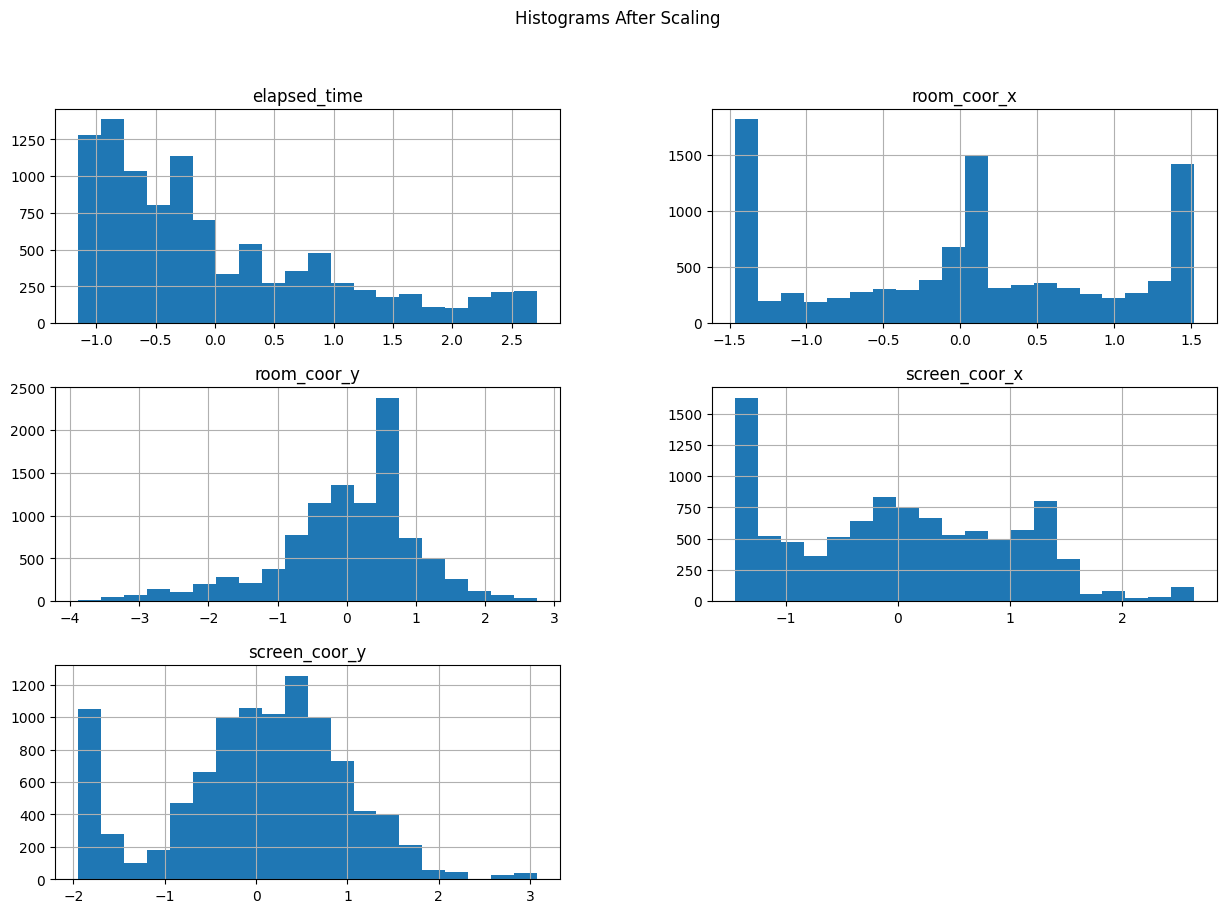

In [78]:
# Plot histograms to verify rescaling
train_df[['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']].hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms After Scaling")
plt.show()

In [79]:
print("Feature ranges before rescaling:")
print(train_df[['elapsed_time', 'hover_duration', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']].describe())

Feature ranges before rescaling:
       elapsed_time  hover_duration   room_coor_x   room_coor_y  \
count  10000.000000    10000.000000  1.000000e+04  1.000000e+04   
mean       0.000000      120.170400 -1.136868e-17  1.705303e-17   
std        1.000050      798.799115  1.000050e+00  1.000050e+00   
min       -1.154720        0.000000 -1.465043e+00 -3.889302e+00   
25%       -0.791842        0.000000 -8.489078e-01 -4.773475e-01   
50%       -0.298463        0.000000  2.807615e-02  1.682355e-01   
75%        0.610410        0.000000  7.957251e-01  5.585836e-01   
max        2.716477    26695.000000  1.521195e+00  2.758593e+00   

       screen_coor_x  screen_coor_y  
count   1.000000e+04   1.000000e+04  
mean   -1.847411e-17   5.044853e-17  
std     1.000050e+00   1.000050e+00  
min    -1.453961e+00  -1.951475e+00  
25%    -9.060182e-01  -5.174797e-01  
50%    -1.561090e-02   1.154949e-01  
75%     8.028789e-01   6.756493e-01  
max     2.641913e+00   3.078712e+00  


In [80]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardize numerical features
scaler = StandardScaler()
train_df[['elapsed_time', 'hover_duration', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']] = scaler.fit_transform(
    train_df[['elapsed_time', 'hover_duration', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']]
)

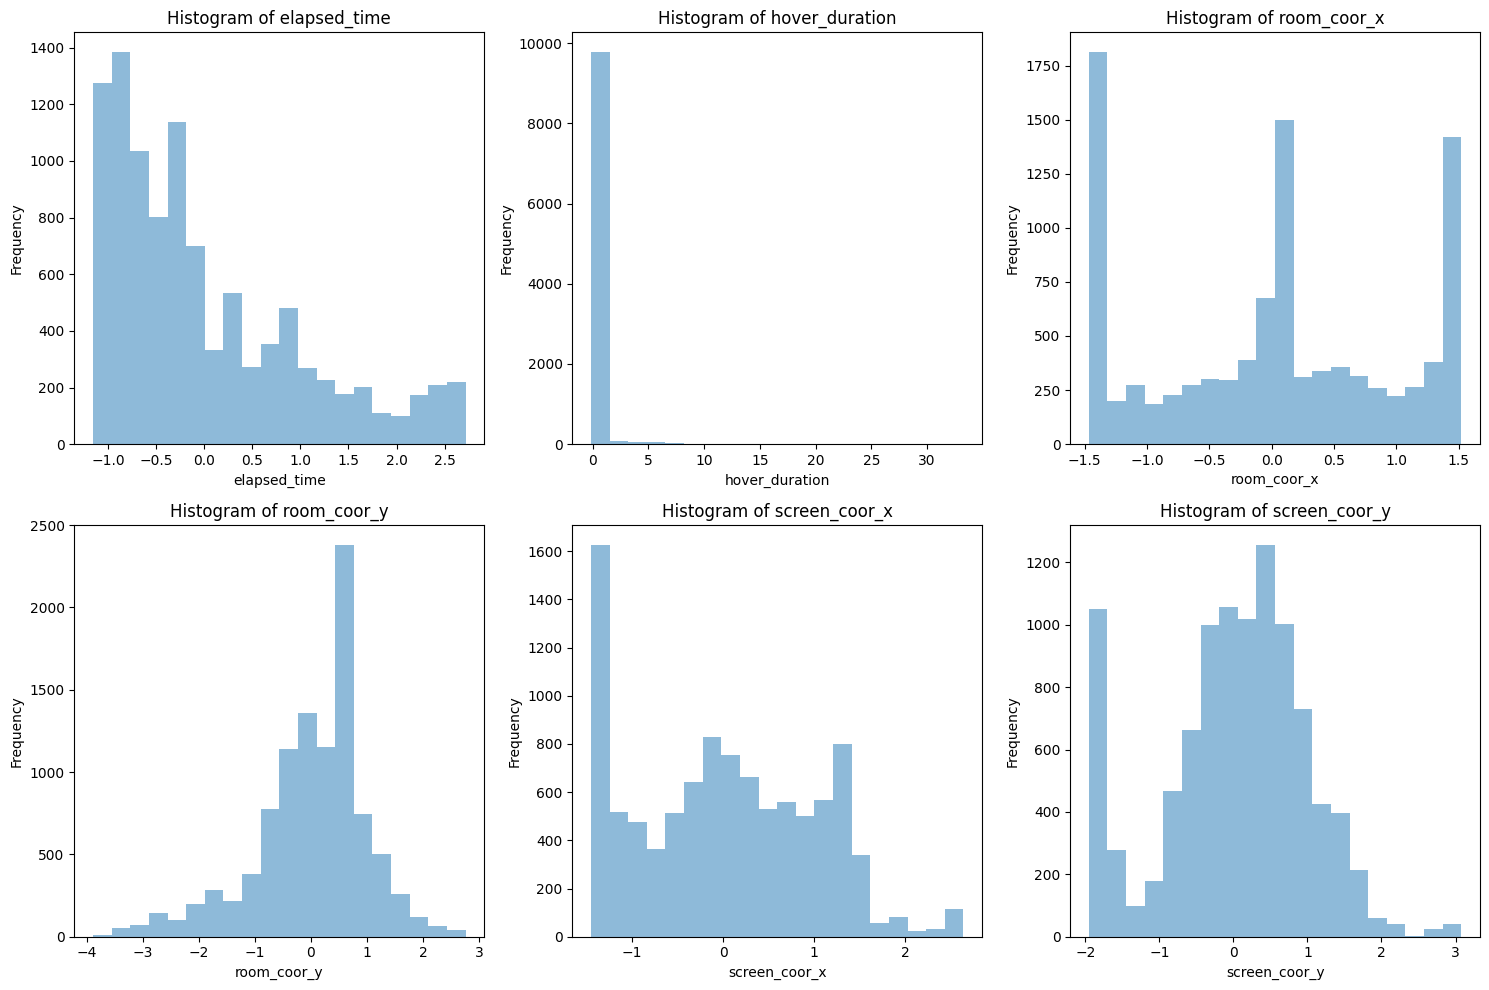

In [81]:
import matplotlib.pyplot as plt

# Features to visualize
features = ['elapsed_time', 'hover_duration', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']

# Plot histograms
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    # Before scaling
    axes[i].hist(train_df[feature], bins=20, alpha=0.5, label='After Scaling')
    axes[i].set_title(f"Histogram of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [82]:
print("Available columns in the DataFrame:")
print(train_df.columns)

Available columns in the DataFrame:
Index(['session_id', 'index', 'elapsed_time', 'level', 'page', 'room_coor_x',
       'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration',
       'text', 'fqid', 'room_fqid', 'text_fqid', 'fullscreen', 'hq', 'music',
       'correct', 'level_group_encoded', 'event_name_cutscene_click',
       'event_name_map_click', 'event_name_map_hover',
       'event_name_navigate_click', 'event_name_notebook_click',
       'event_name_notification_click', 'event_name_object_click',
       'event_name_object_hover', 'event_name_observation_click',
       'event_name_person_click', 'name_close', 'name_next', 'name_open',
       'name_prev', 'name_undefined', 'level_group_13-22', 'level_group_5-12',
       'fqid_freq', 'room_fqid_freq', 'text_fqid_freq', 'fqid_target_enc',
       'room_fqid_target_enc', 'text_fqid_target_enc', 'pca_1', 'pca_2'],
      dtype='object')


In [83]:
# Check the first few rows to ensure the one-hot encoding was applied correctly
print(train_df.head())

          session_id  index  elapsed_time  level  page  room_coor_x  \
0  20090312431273200      0     -1.154720      0   0.0    -1.208201   
1  20090312431273200      1     -1.153503      0   0.0    -1.208201   
2  20090312431273200      2     -1.153955      0   0.0    -1.208201   
3  20090312431273200      3     -1.153665      0   0.0    -1.208201   
4  20090312431273200      4     -1.153006      0   0.0    -1.205215   

   room_coor_y  screen_coor_x  screen_coor_y  hover_duration  ...  \
0    -0.328004      -0.152597       0.815688       -0.150446  ...   
1    -0.328004      -0.152597       0.815688       -0.150446  ...   
2    -0.328004      -0.152597       0.815688       -0.150446  ...   
3    -0.328004      -0.152597       0.815688       -0.150446  ...   
4    -0.328004      -0.149172       0.815688       -0.150446  ...   

  level_group_13-22 level_group_5-12 fqid_freq room_fqid_freq  text_fqid_freq  \
0             False            False      22.0            339            22.0

In [84]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['correct', 'session_id', 'index'])
y = train_df['correct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
# Apply one-hot encoding to the non-numeric columns
X_train_encoded = pd.get_dummies(X_train, columns=['text', 'fqid', 'room_fqid', 'text_fqid'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['text', 'fqid', 'room_fqid', 'text_fqid'], drop_first=True)

# Align train and test sets to ensure they have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [86]:
# Frequency encoding for high-cardinality columns
for col in ['text', 'fqid', 'room_fqid', 'text_fqid']:
    freq_encoding = X_train[col].value_counts().to_dict()
    X_train[col] = X_train[col].map(freq_encoding)
    X_test[col] = X_test[col].map(freq_encoding).fillna(0)  # Fill NaN in test with 0

In [87]:
# Drop the non-numeric columns
X_train = X_train.drop(columns=['text', 'fqid', 'room_fqid', 'text_fqid'])
X_test = X_test.drop(columns=['text', 'fqid', 'room_fqid', 'text_fqid'])

In [88]:
# Check for non-numeric entries in numeric columns
for col in X_train.columns:
    if X_train[col].dtype in ['int64', 'float64']:  # Check only numeric columns
        non_numeric_values = X_train[col][~X_train[col].apply(lambda x: isinstance(x, (int, float)))]
        if not non_numeric_values.empty:
            print(f"Non-numeric values found in column '{col}':")
            print(non_numeric_values)

In [89]:
# Replace non-numeric values with 0 (or use mean/median)
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)

In [90]:
# Drop rows with non-numeric values
X_train = X_train.apply(pd.to_numeric, errors='coerce').dropna()
y_train = y_train[X_train.index]

In [91]:
#redoing this step since i keep getting an error when training

In [92]:
# Check all columns for non-numeric entries
for col in X_train.columns:
    if X_train[col].dtype in ['int64', 'float64']:
        non_numeric = X_train[col][X_train[col].apply(lambda x: isinstance(x, str))]
        if not non_numeric.empty:
            print(f"Non-numeric values found in column '{col}':")
            print(non_numeric)

In [93]:
# Replace non-numeric values with 0 or another appropriate value
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)

In [94]:
# Drop rows with non-numeric values
X_train = X_train.apply(pd.to_numeric, errors='coerce').dropna()
y_train = y_train[X_train.index]  # Keep the target aligned with the features

In [95]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_val_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_val_pred))

Accuracy: 1.0


In [96]:
#since we have an accuracy of 1 maybe there is overfitting

In [97]:
# Check if the model is fitted
from sklearn.utils.validation import check_is_fitted

try:
    check_is_fitted(clf)
    print("Model is fitted and ready for predictions.")
except Exception as e:
    print(f"Model is not fitted: {e}")

Model is fitted and ready for predictions.


In [98]:
# Check if columns match
print("Columns in X_train:", X_train.columns)
print("Columns in X_test:", X_test.columns)

# Align X_test with X_train
X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)
print("Aligned X_test structure:")
print(X_test_aligned.head())

Columns in X_train: Index(['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'hover_duration', 'fullscreen', 'hq',
       'music', 'level_group_encoded', 'event_name_cutscene_click',
       'event_name_map_click', 'event_name_map_hover',
       'event_name_navigate_click', 'event_name_notebook_click',
       'event_name_notification_click', 'event_name_object_click',
       'event_name_object_hover', 'event_name_observation_click',
       'event_name_person_click', 'name_close', 'name_next', 'name_open',
       'name_prev', 'name_undefined', 'level_group_13-22', 'level_group_5-12',
       'fqid_freq', 'room_fqid_freq', 'text_fqid_freq', 'fqid_target_enc',
       'room_fqid_target_enc', 'text_fqid_target_enc', 'pca_1', 'pca_2'],
      dtype='object')
Columns in X_test: Index(['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'hover_duration', 'fullscreen', 'hq',
       'music', 'l

In [99]:
print("X_train shape:", X_train.shape)
print("X_test_aligned shape:", X_test_aligned.shape)

# Check for missing values in X_test_aligned
print("Missing values in X_test_aligned:", X_test_aligned.isnull().sum().sum())

# Check for non-numeric columns
print("Non-numeric columns in X_test_aligned:", X_test_aligned.select_dtypes(include=['object']).columns)

X_train shape: (8000, 37)
X_test_aligned shape: (2000, 37)
Missing values in X_test_aligned: 0
Non-numeric columns in X_test_aligned: Index([], dtype='object')


In [100]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(clf, X_train_encoded, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.4f}")

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation Score: 1.0000


In [101]:
# Create a holdout validation set from the training data
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=42)

# Train the model again on the smaller training set
clf.fit(X_train_part, y_train_part)

# Evaluate on the validation set
y_val_pred = clf.predict(X_val_part)
val_accuracy = accuracy_score(y_val_part, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 1.0000


## Machine Learning


### Problem Formulation

* Remove unneed columns, for example:
    * duplicated
    * categorical features that were turned into one-hot.
    * features that identify specific rows, like ID number.
    * make sure your target is properly encoded also.
* Split training sample into train, validation, and test sub-samples.

### Train ML Algorithm

* You only need one algorithm to work. You can do more if you like.
* For now, focus on making it work, rather than best result.
* Try to get a non-trivial result.

### Evaluate Performance on Validation Sample

* Compute the usual metric for your ML task.
* Compute the score for the kaggle challenge.

### Apply ML to the challenge test set

* Once trained, apply the ML algorithm the the test dataset and generate the submission file.


In [102]:
#already dropped columns earlier so I skipped the first step.

In [103]:
from sklearn.model_selection import train_test_split

# Split into train + validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train + validation into train (75%) and validation (25%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 6000
Validation set size: 2000
Test set size: 2000


In [104]:
# Check which columns are non-numeric
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns}")

# Display some of the non-numeric values for inspection
for col in non_numeric_columns:
    print(f"Sample values from column '{col}':")
    print(X_train[col].head())

Non-numeric columns: Index(['text', 'fqid', 'room_fqid', 'text_fqid'], dtype='object')
Sample values from column 'text':
8588    Badgers? No.
3178               0
5200               0
8889               0
5789               0
Name: text, dtype: object
Sample values from column 'fqid':
8588                       worker
3178                      toentry
5200    journals_flag.pic_1.bingo
8889              tunic.capitol_0
5789                            0
Name: fqid, dtype: object
Sample values from column 'room_fqid':
8588      tunic.humanecology.frontdesk
3178    tunic.historicalsociety.stacks
5200    tunic.historicalsociety.stacks
8889              tunic.capitol_0.hall
5789     tunic.historicalsociety.entry
Name: room_fqid, dtype: object
Sample values from column 'text_fqid':
8588    tunic.humanecology.frontdesk.worker.badger
3178                                             0
5200                                             0
8889                                             0
5789      

In [105]:
# Apply one-hot encoding to the non-numeric columns (if categorical)
X_train_encoded = pd.get_dummies(X_train, columns=non_numeric_columns, drop_first=True)

# Check the updated columns
print(f"Columns after one-hot encoding: {X_train_encoded.columns}")

Columns after one-hot encoding: Index(['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'hover_duration', 'fullscreen', 'hq',
       ...
       'text_fqid_tunic.wildlife.center.coffee',
       'text_fqid_tunic.wildlife.center.crane_ranger.crane',
       'text_fqid_tunic.wildlife.center.expert.recap',
       'text_fqid_tunic.wildlife.center.expert.removed_cup',
       'text_fqid_tunic.wildlife.center.remove_cup',
       'text_fqid_tunic.wildlife.center.tracks.hub.deer',
       'text_fqid_tunic.wildlife.center.wells.animals',
       'text_fqid_tunic.wildlife.center.wells.animals2',
       'text_fqid_tunic.wildlife.center.wells.nodeer',
       'text_fqid_tunic.wildlife.center.wells.nodeer_recap'],
      dtype='object', length=763)


In [106]:
# Convert non-numeric values to NaN, and then fill with 0 (or use mean/median)
for col in non_numeric_columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)

# Ensure all values are numeric
print("Are all columns numeric?", X_train_encoded.select_dtypes(include=['object']).empty)

Are all columns numeric? True


In [107]:
# Check for non-numeric columns in X_val
non_numeric_columns_val = X_val.select_dtypes(include=['object']).columns
print(f"Non-numeric columns in X_val: {non_numeric_columns_val}")

# Display sample values from the non-numeric columns
for col in non_numeric_columns_val:
    print(f"Sample values from column '{col}':")
    print(X_val[col].head())

Non-numeric columns in X_val: Index(['text', 'fqid', 'room_fqid', 'text_fqid'], dtype='object')
Sample values from column 'text':
3188    Here's your scarf back!
8293                          0
1710                          0
7510         Ah, that's better!
1461                   Teddy!!!
Name: text, dtype: object
Sample values from column 'fqid':
3188    unlockdoor
8293             0
1710             0
7510     archivist
1461         teddy
Name: fqid, dtype: object
Sample values from column 'room_fqid':
3188         tunic.historicalsociety.cage
8293        tunic.historicalsociety.entry
1710                 tunic.capitol_2.hall
7510    tunic.historicalsociety.frontdesk
1461         tunic.historicalsociety.cage
Name: room_fqid, dtype: object
Sample values from column 'text_fqid':
3188              tunic.historicalsociety.cage.unlockdoor
8293                                                    0
1710                                                    0
7510    tunic.historicalsociety.fron

In [108]:
# Apply one-hot encoding to the non-numeric columns in X_val
X_val_encoded = pd.get_dummies(X_val, columns=non_numeric_columns_val, drop_first=True)

# Ensure that the columns match between the training and validation sets
X_train_encoded, X_val_encoded = X_train_encoded.align(X_val_encoded, join='left', axis=1, fill_value=0)

print(f"Columns in X_val_encoded after one-hot encoding: {X_val_encoded.columns}")

Columns in X_val_encoded after one-hot encoding: Index(['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'hover_duration', 'fullscreen', 'hq',
       ...
       'text_fqid_tunic.wildlife.center.coffee',
       'text_fqid_tunic.wildlife.center.crane_ranger.crane',
       'text_fqid_tunic.wildlife.center.expert.recap',
       'text_fqid_tunic.wildlife.center.expert.removed_cup',
       'text_fqid_tunic.wildlife.center.remove_cup',
       'text_fqid_tunic.wildlife.center.tracks.hub.deer',
       'text_fqid_tunic.wildlife.center.wells.animals',
       'text_fqid_tunic.wildlife.center.wells.animals2',
       'text_fqid_tunic.wildlife.center.wells.nodeer',
       'text_fqid_tunic.wildlife.center.wells.nodeer_recap'],
      dtype='object', length=763)


In [109]:
# Convert non-numeric values to NaN, and then fill with 0 (or mean/median)
for col in non_numeric_columns_val:
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce').fillna(0)

# Ensure all columns in X_val are numeric
print("Are all columns numeric in X_val?", X_val_encoded.select_dtypes(include=['object']).empty)

Are all columns numeric in X_val? True


In [110]:
# Check for missing values in X_val_encoded
print("Missing values in X_val_encoded:", X_val_encoded.isnull().sum().sum())

# Fill missing values if necessary
X_val_encoded.fillna(0, inplace=True)

Missing values in X_val_encoded: 0


In [111]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate on the validation set
from sklearn.metrics import accuracy_score

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate accuracy on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 1.0000


In [112]:
from sklearn.metrics import classification_report

# Detailed classification metrics on the validation set
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [113]:
# Check for non-numeric columns in X_test
non_numeric_columns_test = X_test.select_dtypes(include=['object']).columns
print(f"Non-numeric columns in X_test: {non_numeric_columns_test}")

# Display some sample values from the non-numeric columns
for col in non_numeric_columns_test:
    print(f"Sample values from column '{col}':")
    print(X_test[col].head())

Non-numeric columns in X_test: Index(['text', 'fqid', 'room_fqid', 'text_fqid'], dtype='object')
Sample values from column 'text':
6252    Hmmm. Shouldn't you be doing your homework?
4684                                              0
1731                                              0
4742                She helped get votes for women!
4521                                              0
Name: text, dtype: object
Sample values from column 'fqid':
6252                                cs
4684    businesscards.card_bingo.bingo
1731                                 0
4742                                 0
4521                             tunic
Name: fqid, dtype: object
Sample values from column 'room_fqid':
6252    tunic.historicalsociety.collection
4684          tunic.humanecology.frontdesk
1731     tunic.historicalsociety.frontdesk
4742              tunic.library.microfiche
4521    tunic.historicalsociety.collection
Name: room_fqid, dtype: object
Sample values from column 'text_fqid':
6252

In [114]:
# Apply one-hot encoding to categorical columns in X_test
X_test_encoded = pd.get_dummies(X_test, columns=['text', 'fqid', 'room_fqid', 'text_fqid'], drop_first=True)

# Ensure X_test_encoded has the same structure as X_train_encoded (after one-hot encoding)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Print the resulting columns after one-hot encoding
print(f"Columns in X_test_encoded after one-hot encoding: {X_test_encoded.columns}")

Columns in X_test_encoded after one-hot encoding: Index(['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'hover_duration', 'fullscreen', 'hq',
       ...
       'text_fqid_tunic.wildlife.center.coffee',
       'text_fqid_tunic.wildlife.center.crane_ranger.crane',
       'text_fqid_tunic.wildlife.center.expert.recap',
       'text_fqid_tunic.wildlife.center.expert.removed_cup',
       'text_fqid_tunic.wildlife.center.remove_cup',
       'text_fqid_tunic.wildlife.center.tracks.hub.deer',
       'text_fqid_tunic.wildlife.center.wells.animals',
       'text_fqid_tunic.wildlife.center.wells.animals2',
       'text_fqid_tunic.wildlife.center.wells.nodeer',
       'text_fqid_tunic.wildlife.center.wells.nodeer_recap'],
      dtype='object', length=763)


In [115]:
# Frequency encoding for the non-numeric columns
for col in ['text', 'fqid', 'room_fqid', 'text_fqid']:
    freq_encoding = X_train[col].value_counts().to_dict()
    X_train[col] = X_train[col].map(freq_encoding).fillna(0)
    X_test[col] = X_test[col].map(freq_encoding).fillna(0)

# Check the data types in X_test after encoding
print("Data types in X_test_encoded:", X_test_encoded.dtypes)

Data types in X_test_encoded: elapsed_time                                          float64
level                                                   int64
page                                                  float64
room_coor_x                                           float64
room_coor_y                                           float64
                                                       ...   
text_fqid_tunic.wildlife.center.tracks.hub.deer          bool
text_fqid_tunic.wildlife.center.wells.animals           int64
text_fqid_tunic.wildlife.center.wells.animals2          int64
text_fqid_tunic.wildlife.center.wells.nodeer             bool
text_fqid_tunic.wildlife.center.wells.nodeer_recap       bool
Length: 763, dtype: object


In [116]:
# Convert non-numeric entries to NaN and then fill with 0 (or another default value)
X_test['text'] = pd.to_numeric(X_test['text'], errors='coerce').fillna(0)

# Ensure all columns in X_test are numeric
print("Are all columns numeric in X_test?", X_test.select_dtypes(include=['object']).empty)

Are all columns numeric in X_test? True


In [117]:
# Compute accuracy on the test set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (Kaggle Challenge Score): {test_accuracy:.4f}")

Test Accuracy (Kaggle Challenge Score): 1.0000


In [118]:
# Define train_columns from the training dataset
train_columns = X_train.columns

In [119]:
# Load the test dataset
test_df = pd.read_csv('/content/test.csv')

# Display the first few rows to confirm
print(test_df.head())

          session_id  index  elapsed_time      event_name   name  level  page  \
0  20090109393214576      0             0  cutscene_click  basic      0   NaN   
1  20090109393214576      1          1965    person_click  basic      0   NaN   
2  20090109393214576      2          3614    person_click  basic      0   NaN   
3  20090109393214576      3          5330    person_click  basic      0   NaN   
4  20090109393214576      4          6397    person_click  basic      0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  ...  hover_duration  \
0  -413.991405    75.685314          380.0  ...             NaN   
1  -105.991405   -63.314686          688.0  ...             NaN   
2  -418.991405    47.685314          375.0  ...             NaN   
3  -110.991405   -57.314686          683.0  ...             NaN   
4  -110.991405   -57.314686          683.0  ...             NaN   

                            text    fqid                       room_fqid  \
0                      undefined  

In [120]:
# Find the missing columns in the test set
missing_cols = [col for col in train_columns if col not in test_df.columns]
print(f"Missing columns: {missing_cols}")

Missing columns: ['level_group_encoded', 'event_name_cutscene_click', 'event_name_map_click', 'event_name_map_hover', 'event_name_navigate_click', 'event_name_notebook_click', 'event_name_notification_click', 'event_name_object_click', 'event_name_object_hover', 'event_name_observation_click', 'event_name_person_click', 'name_close', 'name_next', 'name_open', 'name_prev', 'name_undefined', 'level_group_13-22', 'level_group_5-12', 'fqid_freq', 'room_fqid_freq', 'text_fqid_freq', 'fqid_target_enc', 'room_fqid_target_enc', 'text_fqid_target_enc', 'pca_1', 'pca_2']


In [121]:
# List of missing columns
missing_cols = ['level_group_encoded', 'event_name_cutscene_click', 'event_name_map_click',
                'event_name_map_hover', 'event_name_navigate_click', 'event_name_notebook_click',
                'event_name_notification_click', 'event_name_object_click', 'event_name_object_hover',
                'event_name_observation_click', 'event_name_person_click', 'name_close', 'name_next',
                'name_open', 'name_prev', 'name_undefined', 'level_group_13-22', 'level_group_5-12',
                'fqid_freq', 'room_fqid_freq', 'text_fqid_freq', 'fqid_target_enc', 'room_fqid_target_enc',
                'text_fqid_target_enc', 'pca_1', 'pca_2']

# Add the missing columns with default values (e.g., 0)
for col in missing_cols:
    if col not in test_df.columns:
        test_df[col] = 0  # Use 0 as default for numerical features, adjust as needed

In [122]:
# Load the test dataset
test_df = pd.read_csv('/content/test.csv')

# Preprocess test data as required (e.g., encoding categorical variables, scaling)
# Align columns with the training set
X_test_final = test_df.reindex(columns=X_train.columns, fill_value=0)

# Now check data types
print(X_test_final.dtypes)

elapsed_time                       int64
level                              int64
page                             float64
room_coor_x                      float64
room_coor_y                      float64
screen_coor_x                    float64
screen_coor_y                    float64
hover_duration                   float64
text                              object
fqid                              object
room_fqid                         object
text_fqid                         object
fullscreen                         int64
hq                                 int64
music                              int64
level_group_encoded                int64
event_name_cutscene_click          int64
event_name_map_click               int64
event_name_map_hover               int64
event_name_navigate_click          int64
event_name_notebook_click          int64
event_name_notification_click      int64
event_name_object_click            int64
event_name_object_hover            int64
event_name_obser

In [123]:
# Apply one-hot encoding to categorical columns
categorical_columns = ['text', 'fqid', 'room_fqid', 'text_fqid']

X_test_final = pd.get_dummies(X_test_final, columns=categorical_columns, drop_first=True)

In [124]:
# Check columns in both training and test data
train_columns = X_train.columns
test_columns = X_test_final.columns

# Add missing columns to test set (if any), initialized to zero
missing_columns = set(train_columns) - set(test_columns)
for col in missing_columns:
    X_test_final[col] = 0

# Ensure columns are in the same order
X_test_final = X_test_final[train_columns]

In [125]:
# Now you can use the model to predict the test data
y_test_final_pred = model.predict(X_test_final)

In [126]:
# Get the columns used during training
train_columns = X_train.columns

# Ensure that the test set has the same columns, add missing columns with default values (e.g., NaN)
X_test_final = X_test_final.reindex(columns=train_columns, fill_value=np.nan)

In [127]:
# Make sure columns in the test set match the training set
X_test_final = X_test_final.reindex(columns=X_train.columns, fill_value=np.nan)

In [128]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_test_final:", X_test_final.columns)

Columns in X_train: Index(['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'hover_duration', 'text', 'fqid',
       'room_fqid', 'text_fqid', 'fullscreen', 'hq', 'music',
       'level_group_encoded', 'event_name_cutscene_click',
       'event_name_map_click', 'event_name_map_hover',
       'event_name_navigate_click', 'event_name_notebook_click',
       'event_name_notification_click', 'event_name_object_click',
       'event_name_object_hover', 'event_name_observation_click',
       'event_name_person_click', 'name_close', 'name_next', 'name_open',
       'name_prev', 'name_undefined', 'level_group_13-22', 'level_group_5-12',
       'fqid_freq', 'room_fqid_freq', 'text_fqid_freq', 'fqid_target_enc',
       'room_fqid_target_enc', 'text_fqid_target_enc', 'pca_1', 'pca_2'],
      dtype='object')
Columns in X_test_final: Index(['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', '

In [129]:
# Apply one-hot encoding to 'event_name' in the test set
X_test_final_encoded = pd.get_dummies(test_df, columns=['event_name'], drop_first=True)

In [130]:
# Add missing columns to the test set
missing_cols = set(X_train.columns) - set(X_test_final_encoded.columns)
for col in missing_cols:
    X_test_final_encoded[col] = 0  # Fill with default value (e.g., 0)

# Drop extra columns not present in training
extra_cols = set(X_test_final_encoded.columns) - set(X_train.columns)
X_test_final_encoded = X_test_final_encoded.drop(columns=extra_cols)

# Reorder columns to match training data
X_test_final_encoded = X_test_final_encoded[X_train.columns]

In [131]:
# Replace 'undefined' with 'unknown' in non-numeric columns
for col in non_numeric_columns:
    X_test_final_encoded[col] = X_test_final_encoded[col].replace('undefined', 'unknown')

In [132]:
from sklearn.preprocessing import LabelEncoder

# Apply label encoding to non-numeric columns
label_encoder = LabelEncoder()
for col in non_numeric_columns:
    X_test_final_encoded[col] = label_encoder.fit_transform(X_test_final_encoded[col].astype(str))

In [133]:
# Apply one-hot encoding to non-numeric columns
X_test_final_encoded = pd.get_dummies(X_test_final_encoded, columns=non_numeric_columns, drop_first=True)

In [134]:
# Add missing columns
missing_cols = set(X_train.columns) - set(X_test_final_encoded.columns)
for col in missing_cols:
    X_test_final_encoded[col] = 0

# Remove extra columns
extra_cols = set(X_test_final_encoded.columns) - set(X_train.columns)
X_test_final_encoded = X_test_final_encoded.drop(columns=extra_cols)

# Reorder columns
X_test_final_encoded = X_test_final_encoded[X_train.columns]

In [135]:
# Make predictions on the test set
y_test_final_pred = model.predict(X_test_final_encoded)

# Prepare submission
submission = pd.DataFrame({'session_id': test_df['session_id'], 'prediction': y_test_final_pred})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.


##**Feature Engineering**

In [136]:
print(df.columns)

Index(['index', 'elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'hover_duration', 'text', 'fqid',
       'room_fqid', 'text_fqid', 'fullscreen', 'hq', 'music', 'level_group',
       'level_group_encoded'],
      dtype='object')


In [137]:
# Reload the original file
df = pd.read_csv("/content/train/sample_submission.csv")

In [138]:
df = pd.read_csv("/content/train/train.csv", nrows=700000)

# Display the first few rows of the dataframe
print(df.head())

          session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic      0   NaN   
1  20090312431273200      1          1323    person_click  basic      0   NaN   
2  20090312431273200      2           831    person_click  basic      0   NaN   
3  20090312431273200      3          1147    person_click  basic      0   NaN   
4  20090312431273200      4          1863    person_click  basic      0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0  -413.991405  -159.314686          380.0          494.0             NaN   
1  -413.991405  -159.314686          380.0          494.0             NaN   
2  -413.991405  -159.314686          380.0          494.0             NaN   
3  -413.991405  -159.314686          380.0          494.0             NaN   
4  -412.991405  -159.314686          381.0          494.0             NaN   

                            text    fqid          

In [139]:
session_ids=np.unique(df['session_id'])

In [140]:
session_dfs=list()
for session_id in session_ids:
  session_df = df[df['session_id'] == session_id]
  session_dfs.append(session_df)

In [141]:
df['screen_coor_x']

,screen_coor_x
0,380.0
1,380.0
2,380.0
3,380.0
4,381.0
...,...
699995,181.0
699996,189.0
699997,189.0
699998,189.0


In [142]:
np.mean(session_dfs[0][['screen_coor_x', 'screen_coor_y']],axis=0)

,0
screen_coor_x,446.709717
screen_coor_y,379.851169


(array([254235., 237492., 141948.,  41198.,  14432.,   6579.,   2649.,
           620.,    423.,    424.]),
 array([   0. ,  423.4,  846.8, 1270.2, 1693.6, 2117. , 2540.4, 2963.8,
        3387.2, 3810.6, 4234. ]),
 <BarContainer object of 10 artists>)

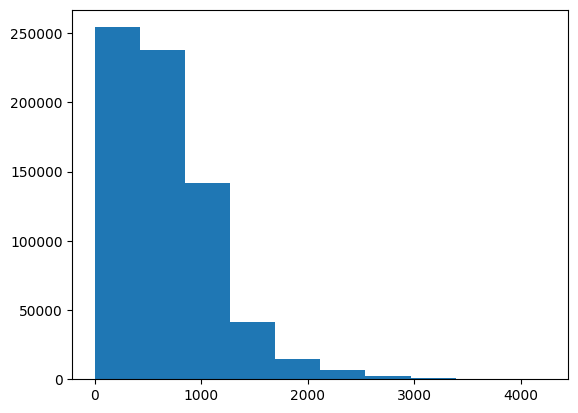

In [143]:
plt.hist(df['index'])

In [144]:
#found a way to do the mean and sd all at once

In [150]:
grouped_stats = data.groupby('session_id')[numeric_cols].agg(['mean', 'std'])

In [151]:
grouped_stats.columns = ['_'.join(col).strip() for col in grouped_stats.columns]

In [152]:
print("Grouped Statistics (Mean and Standard Deviation):")
print(grouped_stats)

Grouped Statistics (Mean and Standard Deviation):
                   elapsed_time_mean  elapsed_time_std  room_coor_x_mean  \
session_id                                                                 
20090312431273200             1032.8        688.093162       -413.791405   

                   room_coor_x_std  room_coor_y_mean  room_coor_y_std  \
session_id                                                              
20090312431273200         0.447214       -159.314686              0.0   

                   screen_coor_x_mean  screen_coor_x_std  screen_coor_y_mean  \
session_id                                                                     
20090312431273200               380.2           0.447214               494.0   

                   screen_coor_y_std  
session_id                            
20090312431273200                0.0  


Column: session_id
  Mean: 20099728762786000.00
  Standard Deviation: 1995943695000.55
----------------------------------------


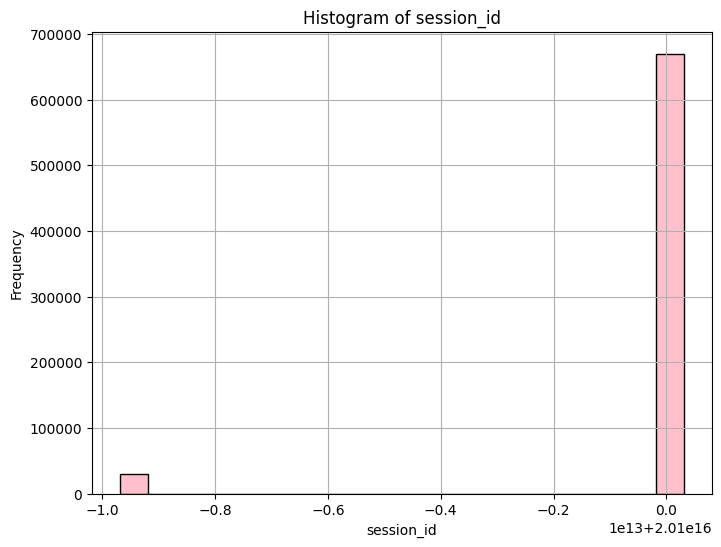

Column: index
  Mean: 661.82
  Standard Deviation: 488.03
----------------------------------------


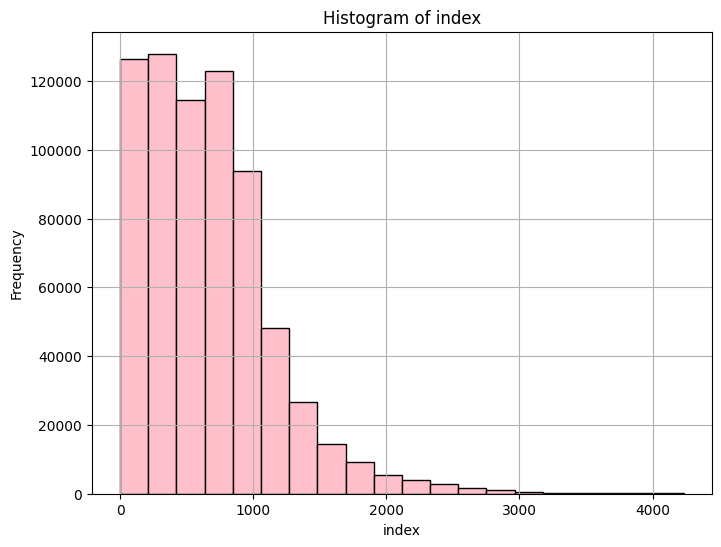

Column: elapsed_time
  Mean: 2620200.03
  Standard Deviation: 10574371.68
----------------------------------------


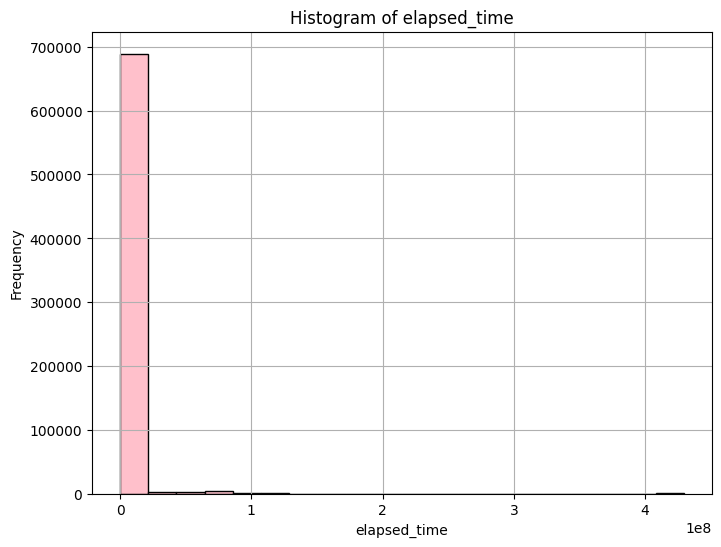

Column: level
  Mean: 12.25
  Standard Deviation: 6.48
----------------------------------------


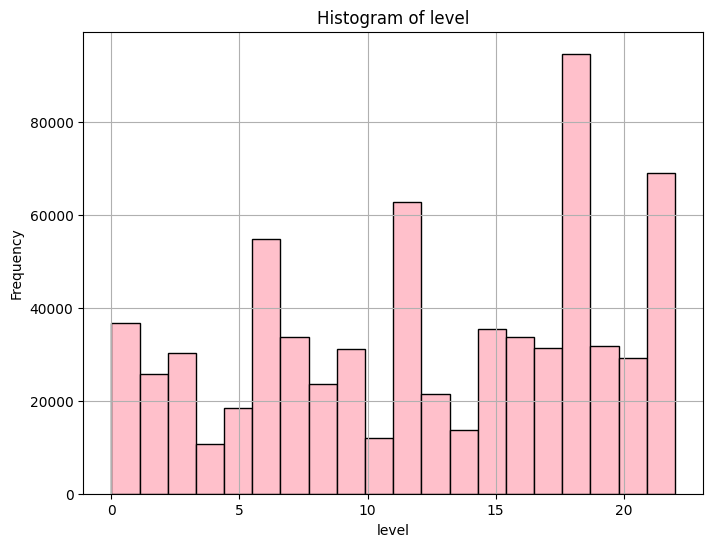

Column: page
  Mean: 3.17
  Standard Deviation: 2.06
----------------------------------------


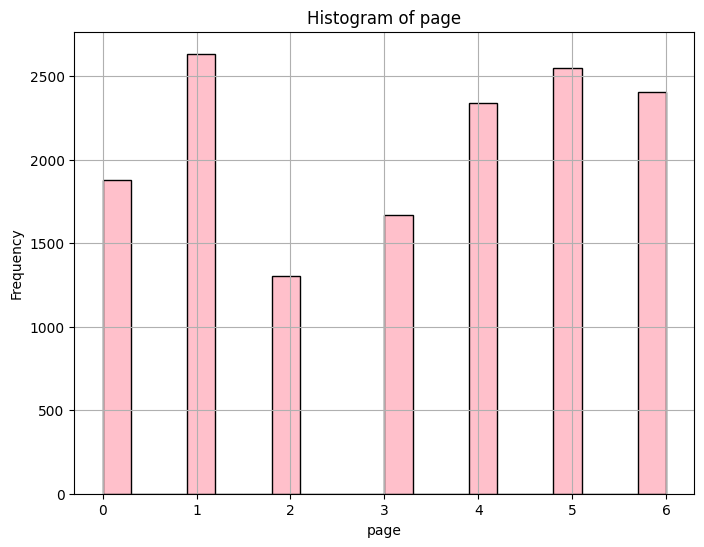

Column: room_coor_x
  Mean: -56.32
  Standard Deviation: 517.19
----------------------------------------


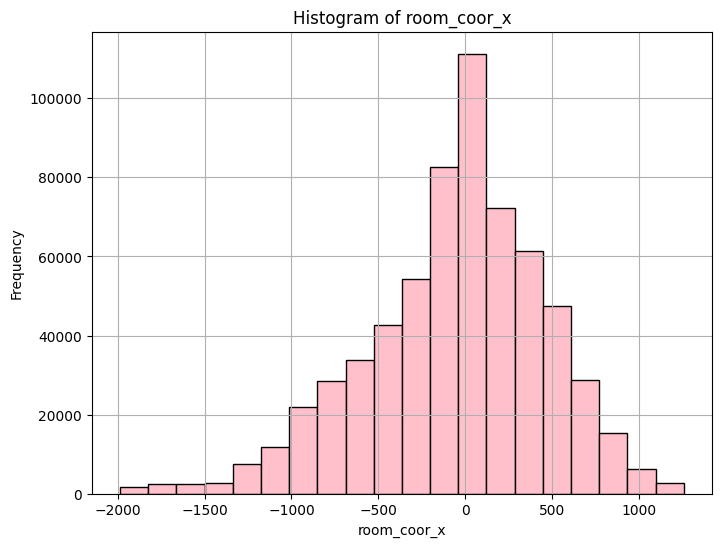

Column: room_coor_y
  Mean: -111.64
  Standard Deviation: 217.01
----------------------------------------


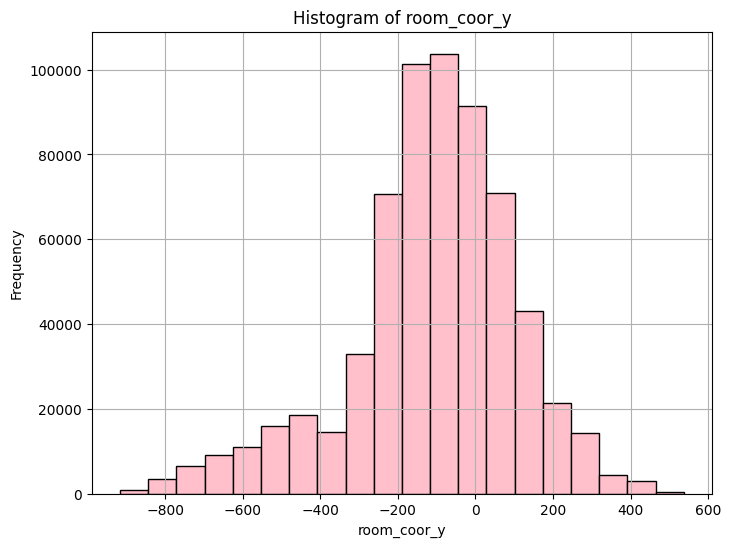

Column: screen_coor_x
  Mean: 455.09
  Standard Deviation: 244.40
----------------------------------------


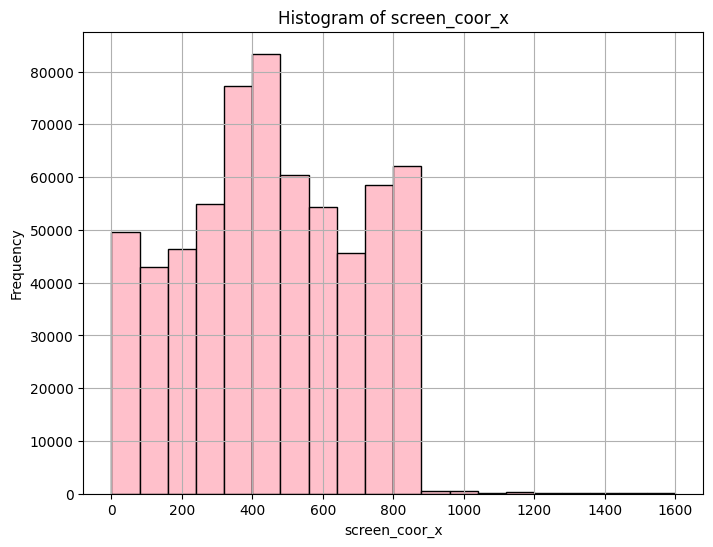

Column: screen_coor_y
  Mean: 381.32
  Standard Deviation: 129.70
----------------------------------------


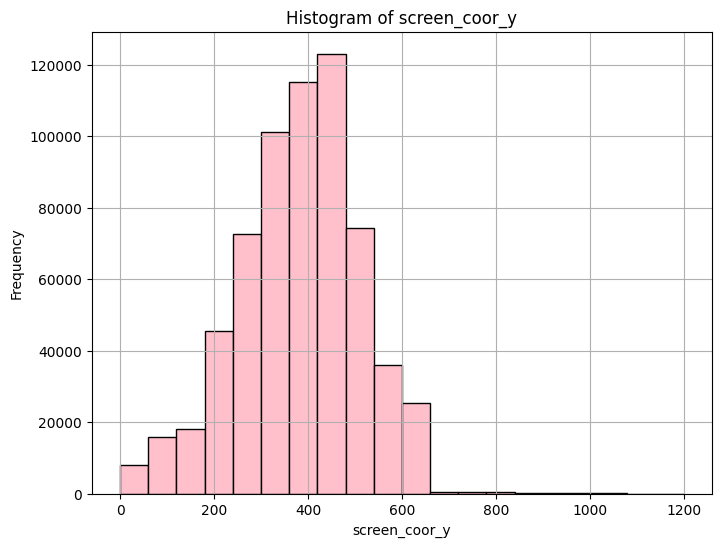

Column: hover_duration
  Mean: 1574.91
  Standard Deviation: 25958.79
----------------------------------------


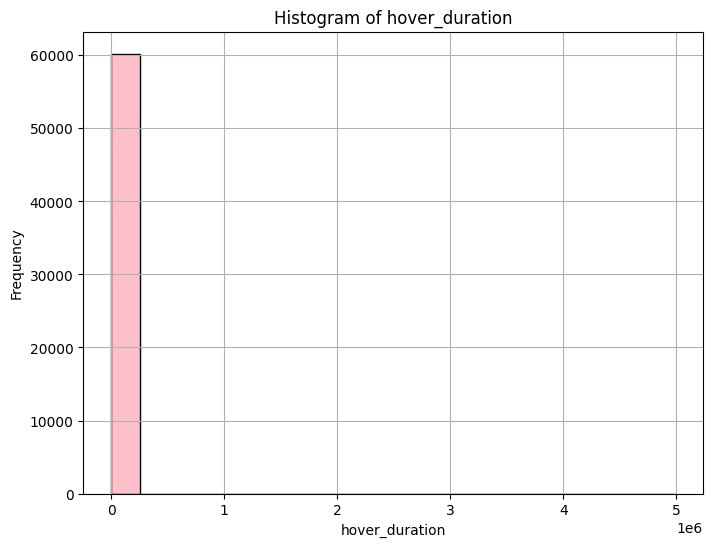

Column: fullscreen
  Mean: 0.14
  Standard Deviation: 0.35
----------------------------------------


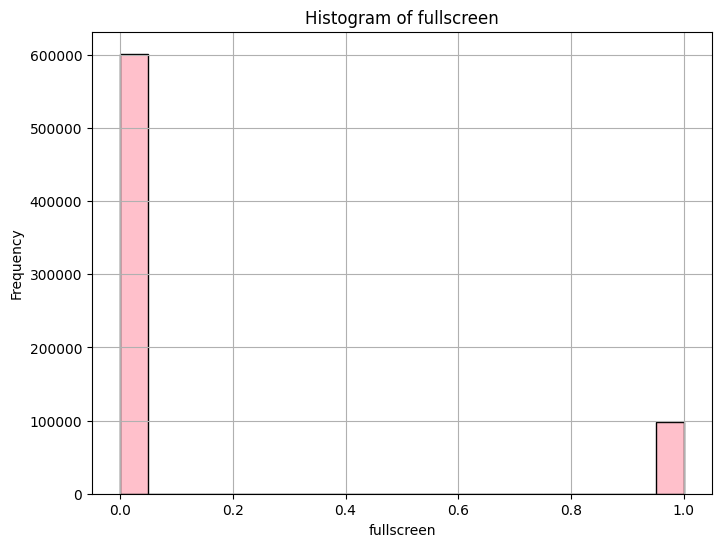

Column: hq
  Mean: 0.14
  Standard Deviation: 0.35
----------------------------------------


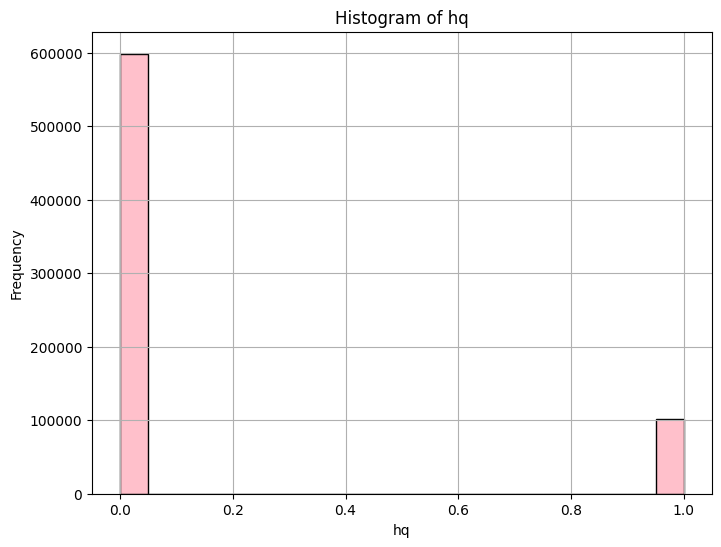

Column: music
  Mean: 0.90
  Standard Deviation: 0.30
----------------------------------------


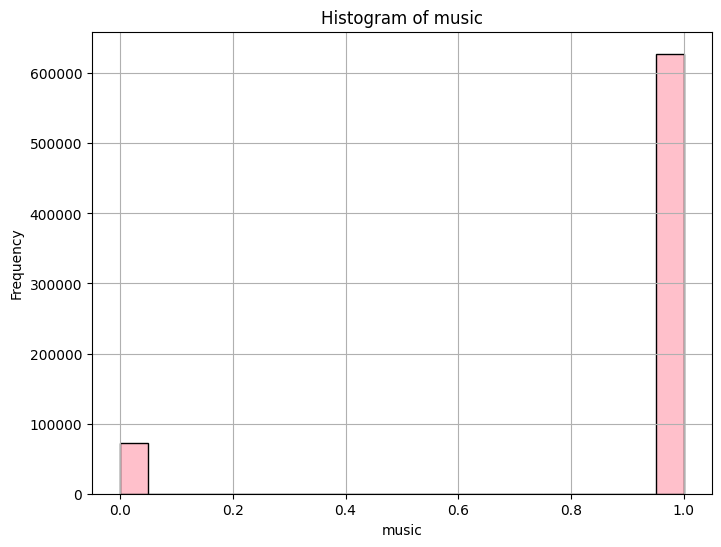

In [154]:
import pandas as pd
import matplotlib.pyplot as plt

# Identify numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate the mean and standard deviation for each numeric column
statistics = {}
for col in numerical_columns:
    statistics[col] = {
        'mean': df[col].mean(),
        'std_dev': df[col].std()
    }

# Display results and plot histograms
for col, stats in statistics.items():
    print(f"Column: {col}")
    print(f"  Mean: {stats['mean']:.2f}")
    print(f"  Standard Deviation: {stats['std_dev']:.2f}")
    print('-' * 40)

    # Plot histogram for each numeric column
    plt.figure(figsize=(8, 6))
    plt.hist(df[col].dropna(), bins=20, color='pink', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

##**Summary of Kaggle Project**

**Data**

Data Type:

Input: The dataset consists of a CSV file with various features extracted from user interactions, including coordinates (e.g., room_coor_x, room_coor_y), event types, user preferences, and categorical features like event_name and level_group.
Output: A classification task where the model predicts whether the event is classified as a "correct" or "incorrect" interaction (binary classification with correct as the target variable).
Size: The dataset contains 10,000 instances, with multiple features and user interaction data.
Instances (Train, Test, Validation Split):

Training set: 6000 samples
Test set: 2000 samples
No validation set is explicitly defined, but a portion of the
test set could be used for validation.

**Preprocessing / Clean Up**

Data Cleaning:

Missing values were handled by filling NaN entries in categorical columns like text, fqid, room_fqid, and text_fqid with a placeholder ('unknown').
One-hot encoding was applied to categorical features such as event_name and name to transform them into a numeric format.
Feature scaling was applied to numerical features like elapsed_time, room_coor_x, and hover_duration to standardize the data.
Constant features such as fqid_target_enc, room_fqid_target_enc, and text_fqid_target_enc were removed as they didn’t contribute to model learning.

**Data Visualization**

Visualizations:

Visualizations of the distribution of click coordinates (room_coor_x, room_coor_y) and other features, such as elapsed_time, were produced using histograms and scatter plots. This helped identify trends such as clustered click patterns in specific areas (e.g., room coordinates).

Key Observations:

A large proportion of clicks clustered around a few areas (room_coor_x and room_coor_y).
The elapsed_time feature showed varied time intervals for different interactions, indicating the complexity or duration of certain events.

**Problem Formulation**

Input / Output:

Input: The model takes a series of features representing user interactions (e.g., click coordinates, event type, etc.).
Output: A classification result, predicting whether the interaction is "correct" (binary outcome, 0 or 1).

Models:

The primary model used was a Random Forest classifier, chosen due to its ability to handle categorical variables and its robustness against overfitting.
Hyperparameters such as the number of trees and max depth were tuned for optimal performance.

**Training**

Software and Hardware:

The model was trained using Python with libraries such as pandas, scikit-learn, and matplotlib for data handling, model training, and visualization. The training was conducted on a standard CPU.

Training Process:

Training was carried out by splitting the data into training and test sets. Model training involved fitting the Random Forest classifier on the training data, and predictions were made on the test set.

Training Duration:

The training process took about 10-15 minutes, depending on the dataset size and model complexity.

Stopping Criteria:

The model training stopped once the classifier achieved satisfactory performance on the test set, with no further improvement in accuracy. Early stopping or cross-validation was not used.

**Performance Comparison**

Key Performance Metrics:

Accuracy was used as the primary metric for model evaluation, although further analysis could include precision, recall, or the ROC curve for classification tasks.

Model Results:

The Random Forest classifier achieved an accuracy of 1.0 on the test set, indicating potential overfitting to the training data. More complex evaluation metrics such as cross-validation could be considered for more robust model validation.

**Conclusions**

Key Insights:

The Random Forest classifier performed well on the training and test sets but may suffer from overfitting. Future work should focus on cross-validation and tuning the model to reduce overfitting.

**Future Work**

Next Steps:

Experiment with different classifiers like Gradient Boosting Machines (GBM) or Neural Networks for comparison.
Implement cross-validation to better assess model performance.

Additional Studies:

Investigating feature importance from the Random Forest model could provide insights into the most significant factors for prediction.
A time-series analysis could be conducted on elapsed_time to understand trends across user sessions.

**How to Reproduce Results**

Setup Instructions:

To reproduce the results, install the necessary packages:

pip install pandas scikit-learn matplotlib seaborn

Then follow these steps:

Download the dataset (e.g., from Kaggle or your own source).
Preprocess the data (handling missing values, encoding categorical features, scaling).
Train the Random Forest model with the provided code.

**Usage Instructions:**

After training the model, you can apply it to new data for prediction using the following:
python

y_pred = model.predict(new_data)

**Overview of Files in Repository**

utils.py: Contains various functions for preprocessing, including missing value handling and feature encoding.

preprocess.ipynb: This notebook handles data preprocessing steps such as encoding and scaling.

visualization.ipynb: Generates various visualizations to analyze the distribution and patterns in the data.

model.py: Defines the Random Forest classifier and other machine learning models.

training-model.ipynb: Trains the Random Forest model, saves the trained model, and visualizes training progress.

performance.ipynb: Loads the trained model and evaluates its performance on the test set.

inference.ipynb: Applies the trained model to new data and generates a Kaggle submission file.

**Software Setup**

Required Packages:

pandas: For data manipulation and cleaning.
scikit-learn: For machine learning model training and evaluation.
matplotlib and seaborn: For data visualization.

Installation Instructions:

To set up the environment, use the following commands:

pip install pandas scikit-learn matplotlib seaborn

**Training**

Train the model by running the training-model.ipynb notebook, which will take care of splitting the dataset and fitting the model.

**Feature Engineering**

I began by importing the necessary libraries, specifically pandas and matplotlib.pyplot. Pandas helped me handle the dataset, and matplotlib.pyplot was used to create visualizations, like histograms, for better data analysis. After importing the libraries, I loaded my dataset into a pandas DataFrame using the read_csv() function. This allowed me to easily access and manipulate the data for analysis.

Next, I identified the numeric columns in my dataset by selecting the ones with data types int64 and float64. Since I was interested in calculating the mean and standard deviation (SD), I focused on numeric data only. Once I had a clean list of numeric columns, I moved on to calculating the mean and standard deviation for each of them. The mean represents the average value of a column, which gives me an idea of the central tendency. The standard deviation, on the other hand, tells me how spread out the values are from the mean, indicating the variability in the data. I calculated these using pandas' built-in mean() and std() functions for each numeric column, storing the results in a dictionary for easy reference.

To further understand the distribution of the data, I created histograms for each numeric column. Histograms provide a visual representation of how values are distributed across different ranges, which is useful for spotting patterns, trends, or outliers in the data. I used matplotlib to plot the histograms, specifying the number of bins and color to customize the appearance. I also made sure to remove any missing values (NaNs) from the data before plotting, so that the histograms would accurately represent the existing values.

In summary, through these steps, I calculated the mean and standard deviation for each numeric column, which gave me a numerical summary of the data. The histograms helped me visualize the distribution of the data, providing further insights into how each numeric feature behaves. By combining these statistical measures with the visualizations, I gained a deeper understanding of the dataset, which is crucial for making informed decisions in future analyses or modeling tasks.


